In [1]:
import tables as tb
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import invisible_cities.io.dst_io as dio

import matplotlib.pyplot as plt
from   mpl_toolkits.mplot3d import Axes3D
from utils.plotting_utils import plot_adaption_hits_to_voxel_scale, plot_cloud_voxels, plot_cloud_voxels_and_hits, plot_3d_hits, plot_3d_vox
from utils.plotting_utils import plot_label_creator

In [2]:
labelled_file = '/Users/mperez/NEXT/data_labelling/examples/h5files/prueba_cut24_productionisaura.h5'

In [3]:
with tb.open_file(labelled_file, 'a') as h5out:
    print(h5out)

/Users/mperez/NEXT/data_labelling/examples/h5files/prueba_cut24_productionisaura.h5 (File) ''
Last modif.: 'Thu Mar  3 10:52:42 2022'
Object Tree: 
/ (RootGroup) ''
/DATASET (Group) ''
/DATASET/BeershebaVoxels (Table(619074,), shuffle, zlib(4)) ''
/DATASET/BinsInfo (Table(1,), shuffle, zlib(4)) ''
/DATASET/ElementCountExample (Table(619074,), shuffle, zlib(4)) ''
/DATASET/ElementCountExample2 (Table(619074,), shuffle, zlib(4)) ''
/DATASET/EventsInfo (Table(3059,), shuffle, zlib(4)) ''
/DATASET/IsauraInfo (Table(4329,), shuffle, zlib(4)) ''
/DATASET/MCHits (Table(763078,), shuffle, zlib(4)) ''
/DATASET/MCVoxels (Table(167700,), shuffle, zlib(4)) ''



In [4]:
labelled_MC_voxels = dio.load_dst(labelled_file, 'DATASET', 'MCVoxels')
labelled_MC_hits   = dio.load_dst(labelled_file, 'DATASET', 'MCHits')
labelled_beersheba_voxels = dio.load_dst(labelled_file, 'DATASET', 'BeershebaVoxels')
eventInfo = dio.load_dst(labelled_file, 'DATASET', 'EventsInfo')
binsInfo  = dio.load_dst(labelled_file, 'DATASET', 'BinsInfo')
ele_count = dio.load_dst(labelled_file, 'DATASET', 'ElementCountExample2')

In [5]:
labelled_beersheba_voxels

xbin  ybin  zbin    energy  binclass   MC_ener  ratio  segclass  \
0         -5    21    69  0.001236         0       NaN    NaN         5   
1         -4    20    69  0.000169         0       NaN    NaN         5   
2         -4    21    69  0.010954         0       NaN    NaN         5   
3         -4    21    70  0.008081         0  0.005233    1.0         2   
4         -4    22    68  0.000420         0       NaN    NaN         5   
...      ...   ...   ...       ...       ...       ...    ...       ...   
619069    10    -6   111  0.000015         0       NaN    NaN         4   
619070    10    -5   110  0.000400         0       NaN    NaN         4   
619071    10    -5   111  0.000317         0       NaN    NaN         4   
619072    10    -4   110  0.000271         0       NaN    NaN         4   
619073    10    -4   111  0.000354         0       NaN    NaN         4   

        dataset_id  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
619069        3058  
619070        3058  
619071        3058  
619072        3058  
619073        3058  

[619074 rows x 9 columns]

In [6]:
voxel_size = (binsInfo.size_x.values[0], binsInfo.size_y.values[0], binsInfo.size_z.values[0])

In [7]:
start_bin = (binsInfo.min_x.values[0], binsInfo.min_y.values[0], binsInfo.min_z.values[0])
total_size = (binsInfo.total_x.values[0], binsInfo.total_y.values[0], binsInfo.total_z.values[0])

In [8]:
idx = 150

In [9]:
event_MC_vox = labelled_MC_voxels[labelled_MC_voxels.dataset_id == idx]
event_MC_hits = labelled_MC_hits[labelled_MC_hits.dataset_id == idx]
event_beersh_vox = labelled_beersheba_voxels[labelled_beersheba_voxels.dataset_id == idx]

In [10]:
xb, yb, zb, Eb, segb = event_beersh_vox.xbin.values, event_beersh_vox.ybin.values, event_beersh_vox.zbin.values, event_beersh_vox.energy.values, event_beersh_vox.segclass.values


In [11]:
x, y, z, E, seg = event_MC_hits.x.values, event_MC_hits.y.values, event_MC_hits.z.values, event_MC_hits.energy.values, event_MC_hits.segclass.values



In [12]:
co = ((x, y, z, E))
cob = ((xb, yb, zb, Eb, segb))

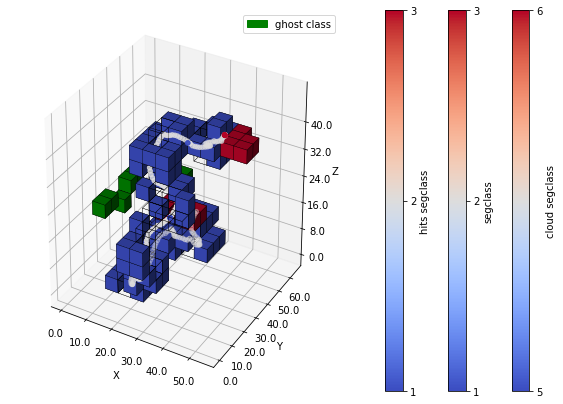

In [13]:
plot_cloud_voxels_and_hits(cob, event_MC_hits, voxel_size, value = ['segclass', 'segclass', 'segclass'])


# Hacer función de labelling "espacial"

La finalidad de esta función es, una vez tengo los datos labelleados, buscar "conjuntos" es decir, buscar todos los que forman un blob, una traza etc y etiquetarlos como b1, b2, ..., t1, t2, ... (por orden de energía, es decir el conjunto de voxeles q formen b1 debe sumar en energía mas que el conjunto de voxeles q formen b2). Lo ideal sería tener siempre b1, luego b2 para los de double scape y t1 para una única traza. Pero ya sabemos de antemano que eso se va a complicar... sobre todo en la predicción...

Otra cosa, primero voy a hacerlo en MC y luego veré de extenderlo a voxeles de beersheba...

In [14]:
import networkx as nx
import itertools

# GROUP UTILS

In [15]:
def create_graph(df, max_distance, coords):
    '''
    Takes a dataframe and creates a graph with the coordinates as nodes, which are connected by edges 
    if they are separated less than certain distance.
    
    Args:
        df: DATAFRAME
    Contains spatial information (at least).
        
        max_distance: FLOAT
    Indicates the maximum distance between nodes to be connected.
        
        coords: LIST OF STR
    Indicates the names of the df columns that have the coordinates info.
    
    RETURNS: 
        graph: NETWORKX GRAPH
    Graph with the nodes and their connections.
    '''
    
    nodes = [tuple(x) for x in df[coords].to_numpy()]
    
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    
    #Ahora hacemos los edges para contar las componentes conexas
    for va, vb in itertools.combinations(graph.nodes(), 2):
        va_arr, vb_arr = np.array(va), np.array(vb)
        dis = np.linalg.norm(va_arr-vb_arr)
        if dis <= max_distance:
            graph.add_edge(va, vb, distance = dis)
    return graph

In [16]:
def add_group_label(global_label, subgraphs, coords, group_label):
    '''
    It creates a dataframe for each subgraph with its nodes and a new label for each one, referred
    to what group it correspond. The label will be A_B, being A the segclass or the name of the 
    general group, and B the specific identificator of this group (as A can have various groups).
    
    Args:
        global_label: STR or INT
    The global name of the group, being usually segclass labels or "c" for cloud.
    
        subgraphs: LIST
    It contains all the connected graphs individually from a global event.
    
        coords: LIST
    Contains the names of the coordinate colums for the dataframe, usually ['x', 'y', 'z']
    
        group_label: STR
    Name for the new column that contains the new information about each group of voxels. We will
    use 'elem' for the small groups of voxels separated by class, and 'cloud' for each set of voxels
    in an event that are close (usually we are going to find the main track and then some other small things)
    
    RETURNS:
        subgraphs_dfs: DATAFRAME
    A dataframme with all the voxeles categorized, either because they belong to a certain group of voxels
    of the same class or because they belong to a group of close voxels in general that form a cloud.
    '''
    
    subgraphs_dfs = pd.DataFrame()
    for j, sgph in enumerate(subgraphs):
        nodes_array = np.array(list(sgph.nodes))
        element_label = np.array([[str(global_label) + '_' + str(j)]] * len(nodes_array))
        
        nodes_array = np.append(nodes_array, element_label, axis = 1)
        
        subgraphs_dfs = subgraphs_dfs.append(pd.DataFrame(nodes_array, columns = coords + [group_label]))
    subgraphs_dfs[coords] = subgraphs_dfs[coords].astype(int)
    return subgraphs_dfs

In [17]:
def order_group_label(global_label, df, subgraph_df, coords, ene_label, group_label):
    '''
    This function takes the output dataframe of add_group_label and joins it to the source dataframe
    where all the voxels information is stored, so we can order each element or cloud by their energy.
    Using the A_B type of labelling, B will take numbers from 0 to the number of groups, being 0 the most
    energetic group.
    
    Args:
        global_label: STR or INT
    The global name of the group, being usually segclass labels or "c" for cloud.

        df: DATAFRAME
    Contains all the voxels information. We want to merge it with the subgraph_df we obtained from the
    add_group_label function so we can sum all the energy per group.
    
        subgraph_df: DATAFRAME
    Contains positions and their group label. It was obtained in the add_group_label function.
    
        coords: LIST
    Contains the names of the coordinate colums for the dataframe, usually ['x', 'y', 'z']
    
        ene_label: STR
    Name for the energy column in the general dataframe (df variable).
    
        group_label: STR
    Name for the new column that contains the new information about each group of voxels. We will
    use 'element' for the small groups of voxels separated by class, and 'cloud' for each set of voxels
    in an event that are close (usually we are going to find the main track and then some other small things)
        
    RETURNS:
        subgraph_df: DATAFRAME
    Contains the unified information from df and the subgraph_df input variable, but with the group labels now
    ordered by energy.
    '''
    
    #We join each subgraph voxel with its energy from the event dataframe
    subgraph_df = subgraph_df.merge(df[coords + [ene_label]], on = coords)
    
    #We create a df with the element label and the sum of the energy of all the voxels of the same element
    #Then arrange it and order from the highest energy to the lowest
    group_label_ener = group_label + '_ener'
    
    elem_ener_df = subgraph_df.groupby(group_label).agg({ene_label:[(group_label_ener, sum)]})
    elem_ener_df.columns = elem_ener_df.columns.get_level_values(1)
    elem_ener_df.reset_index(inplace=True)
    elem_ener_df = elem_ener_df.sort_values(group_label_ener, ascending = False)
    elem_ener_df = elem_ener_df.reset_index(drop = True)
    
    #We now sort the element labels in an array to append to elem_ener_df just like that, so now they
    #are sorted by energy
    order_idx = np.array([str(global_label) + '_' + str(idx) for idx in elem_ener_df.index]) 
    order_idx = np.sort(order_idx).T
    elem_ener_df = elem_ener_df.join(pd.DataFrame(order_idx, columns = ['order_elem']))

    #We join the new ordered element label and merge it with its coordinates by 'element'
    #We drop the energy so is not repeated, the old element and rename the new ordered element as simply element
    subgraph_df = subgraph_df.merge(elem_ener_df, on = [group_label]).drop([ene_label, group_label], axis = 1)
    subgraph_df = subgraph_df.rename(columns={'order_elem': group_label})
    
    return subgraph_df

In [18]:
def label_ordered_elements(df, max_distance, coords, ene_label, seg_label = 'segclass', group_label = 'elem'):
    '''
    This function uses the add_group_label to give to each group of voxels with the same segclass a label that
    identifies them, and then the order_group_label orders their label names by their energy.
    
    Args:
        df: DATAFRAME
    Contains all the voxels information. We will group it by segclass label and then perform the group label
    for each segclass.
    
        max_distance: FLOAT
    Indicates the maximum distance between nodes to be connected.
    
        coords: LIST
    Contains the names of the coordinate colums for the dataframe, usually ['x', 'y', 'z']
    
        ene_label: STR
    Name for the energy column in the general dataframe (the df variable).
    
        seg_label: STR
    Name for the segclass column in the general dataframe (the df variable).
    
        group_label: STR
    Name for the new column that contains the new information about each group of voxels. We will
    use 'element' for the small groups of voxels separated by class.
        
    RETURNS:
        df: DATAFRAME
    The input df variable but with two new columns: elem, that contains the segclass_group label, and 
    elem_ener, that contains the energy for each group.
    '''
    
    df_element = pd.DataFrame()
    for seg, seg_df in df.groupby(seg_label):
        graph = create_graph(seg_df, max_distance, coords)
            
        #Dividimos en subgraphs conectadas       
        subgraphs = [graph.subgraph(sc) for sc in nx.connected_components(graph)]
    
        #Labelleamos los distintos elementos conectados de una misma segclass
        subgraph_df = add_group_label(seg, subgraphs, coords, group_label)
    
        #aqui va a ir la funcion de ordenar por energía!!
        subgraph_df = order_group_label(seg, seg_df, subgraph_df, coords, ene_label, group_label)
        
        #Añadimos en una columna la información del número de elementos total (es decir, el numero de
        #subgraphs para una etiqueta)
        subgraph_df.insert(len(subgraph_df.columns), group_label + '_count', np.zeros(len(subgraph_df)) + len(subgraphs))

        #vamos juntando todos para tener al final un df completo
        df_element = df_element.append(subgraph_df)
    
    df = df.merge(df_element, on = coords)
    return df

La unica diferencia entre label ordered elements y clouds es q en el primero se hace agrupaciones de segclass hits... incluso podríamos poner creo ese bucle fuera de la función y usar la misma PERO me da miedo cagarla ahora así que lo voy a dejar así

In [19]:
def label_ordered_clouds(df, max_distance, coords, ene_label, group_label = 'cloud', cloud_label = 'c'):
    '''
    Analogue function to the label_ordered_elements but done for all the voxels, so now the groups are the 
    clouds of each event.
    
    Args:
        df: DATAFRAME
    Contains all the voxels information.
    
        max_distance: FLOAT
    Indicates the maximum distance between nodes to be connected.
    
        coords: LIST
    Contains the names of the coordinate colums for the dataframe, usually ['x', 'y', 'z']
    
        ene_label: STR
    Name for the energy column in the general dataframe (the df variable).
    
        seg_label: STR
    Name for the segclass column in the general dataframe (the df variable).
    
        group_label: STR
    Name for the new column that contains the new information about each group of voxels. We will
    use 'cloud' for the groups of voxels held in an event.
    
        cloud_label: STR
    Identificator for the label of each group; we will use 'c'.
        
    RETURNS:
        df: DATAFRAME
    The input df variable but with two new columns: cloud, that contains the c_group label, and 
    cloud_ener, that contains the energy for each group.
    '''
    
    #Creo la graph con todos los voxeles de un evento
    graph = create_graph(df, max_distance, coords)
    
    #Separo en subgraphs
    subgraphs = [graph.subgraph(sc) for sc in nx.connected_components(graph)]
    
    #Les añado la etiqueta a los voxeles de cada subgraph cloud
    subgraph_df = add_group_label(cloud_label, subgraphs, coords, group_label)
    
    #Ordeno las clouds de mayor a menor energía
    subgraph_df = order_group_label(cloud_label, df, subgraph_df, coords, ene_label, group_label)
    
    #Añadimos en una columna la información del número de elementos total (es decir, el numero de
    #subgraphs para una etiqueta)
    subgraph_df.insert(len(subgraph_df.columns), group_label + '_count', np.zeros(len(subgraph_df)) + len(subgraphs))

    #Uno esta nueva información al df principal
    df = df.merge(subgraph_df, on = coords)
    return df

In [20]:
def transform_into_df(voxels_info,  
                      coords = ['x', 'y', 'z'], 
                      identifyer = 'dataset_id', 
                      ene_label = 'ener', 
                      seg_label = 'segclass'):
    '''
    This function transforms the input into a DF to use the element labelling functions.
    
    Args: 
        voxels_info: DATAFRAME or TUPLE/ARRAY/LIST of TUPLES/ARRAYS/LISTS in any combination
    It should contain per event its dataset_id and the positions, energy and segclass of the voxels. 
    If we don't use a DataFrame, the input must have the structure (dataset_id, x, y, z, energy, segclass).
    Its shape will be (6, N).
    
        coords: LIST
    Contains the names of the coordinate colums for the dataframe, usually ['x', 'y', 'z']
    
        identifyer: STR
    Name for the column of the event identifyer.
    
        ene_label: STR
    Name for the energy column.
    
        seg_label: STR
    Name for the segclass column.
    
    RETURNS: 
        voxels_info: DATAFRAME
    It's simply the same DF as the input or the set of values turned into a DF
    '''
    if type(voxels_info) == type(pd.DataFrame()):
        pass
    else:
        positions = np.array(voxels_info).T
        voxels_info = pd.DataFrame(positions, columns = [identifyer] + coords + [ene_label, seg_label])
    return voxels_info

In [21]:
def count_blobs_from_labelling(grouped_voxels, blob_class = [3, 6], identifyer = 'dataset_id', seg_label = 'segclass'):
    '''
    This function takes the _count columns (which have the number of groups of a certain group,i.e. the number
    of clouds or the number of a certain element of a certain class) and counts the blobs (number of groups of the 
    element with segclass blob). Also, gives a True if the number of blobs counted corresponds to the binclas (2 blobs
    for the 1 binclass, 1 blob for the 0 binclass), and a False if it doesn't, in the blob_success column.
    
    Args:
        grouped_voxels: DATAFRAME
    The final stage of the dataframe inside the label_event_elements function. It should have the elem_count column.
    
        blob_class: LIST
    Contains the segclass values we want to count as a blob.
    
        identifyer: STR
    Name for the column of the event identifyer.
    
        seg_label: STR
    Name for the segclass column.
    
    RETURNS:
        grouped_voxels: DATAFRAME
    The same DF as the input with the nblob and blob_success columns.
    '''
    
    blob_count_df = pd.DataFrame()
    
    for dat_id, event_df in grouped_voxels.groupby(identifyer):
        nblob = event_df[np.isin(event_df[seg_label], blob_class)].elem_count.unique()
        
        if np.size(nblob) == 0:
            nblob = np.array([0])
        
        blob_count = nblob == event_df.binclass.unique() + 1
        blob_count_df = blob_count_df.append({identifyer: dat_id, 'nblob': nblob[0], 'blob_success': blob_count[0]}, ignore_index=True)
    
    #Make integer
    for colname in blob_count_df.columns:
        blob_count_df[colname] = pd.to_numeric(blob_count_df[colname], downcast = 'integer')
    
    #Make bool
    blob_count_df['blob_success'] = blob_count_df['blob_success'].astype('bool')
    
    #Merge
    grouped_voxels = grouped_voxels.merge(blob_count_df, on = [identifyer])
    
    return grouped_voxels
        

In [22]:
def label_event_elements(labelled_voxels, 
                         max_distance, 
                         coords = ['x', 'y', 'z'], 
                         identifyer = 'dataset_id', 
                         ene_label = 'ener', 
                         seg_label = 'segclass',
                         beersh_dict = None, 
                         blob_class = [3, 6]):
    '''
    The function performs the element (by segclass) and cloud labelling for a bunch of events.
    
    Args:
        labelled_voxels: DATAFRAME or TUPLE/ARRAY/LIST of TUPLES/ARRAYS/LISTS in any combination
    It should contain per event its dataset_id and the positions, energy and segclass of the voxels. 
    If we don't use a DataFrame, the input must have the structure (dataset_id, x, y, z, energy, segclass).
    Its shape will be (6, N).
    
        max_distance: FLOAT
    Indicates the maximum distance between nodes to be connected.
        
        coords: LIST
    Contains the names of the coordinate colums for the dataframe, usually ['x', 'y', 'z']
    
        identifyer: STR
    Name for the column of the event identifyer.
    
        ene_label: STR
    Name for the energy column.
    
        seg_label: STR
    Name for the segclass column.
    
        beersh_dict: DICT or None
    Has the correspondance between classes, so we can group neighbour classes with original classes
    by asigning them the same number (i.e. the dict can have class 1 - other and class 4 - other neighbour marked
    with the number 1, so they are grouped together by this algorythm). An example of this is using 
    beersh_dict = {1:1, 2:2, 3:3, 4:1, 5:2, 6:3, 7:7}, so we can group beersheba label-like voxels. This will be
    the main configuration for beersheba labelled voxels.
    If None, the function will count the groups of exact segclass.
    
        blob_class: LIST
    Contains the segclass values we want to count as a blob.
    
    RETURNS:
        output_df: DATAFRAME
    Contains the same information as de DF/set of values of the labelled_voxels input, with the new columns
    for the element label, the element energy, the cloud label and the cloud energy.
    '''
    
    labelled_voxels = transform_into_df(labelled_voxels, 
                                        coords = coords, 
                                        identifyer = identifyer, 
                                        ene_label = ene_label, 
                                        seg_label = seg_label)
    #If we have a correspondance dictionary, we create a new column that renames the neighbour segclass as
    #the original segclass, and change the segclass label to the name of this new column. At the end we can delete
    #it if we want
    if beersh_dict != None:
        labelled_voxels = labelled_voxels.assign(group_segclass = labelled_voxels[seg_label].map(beersh_dict))
        seg_label = 'group_segclass'
        
    output_df = pd.DataFrame()
    for idx, df_event in labelled_voxels.groupby(identifyer):
        
        df_event  = label_ordered_elements(df_event, max_distance, coords, ene_label, seg_label = seg_label)
        df_event  = label_ordered_clouds(df_event, max_distance, coords, ene_label)
        
        output_df = output_df.append(df_event, ignore_index=True)
    
    output_df = count_blobs_from_labelling(output_df, 
                                           blob_class = blob_class, 
                                           identifyer = identifyer, 
                                           seg_label = seg_label)
    #We drop this auxiliary column
    if beersh_dict != None:
        output_df = output_df.drop(seg_label, axis = 1)
        
    return output_df

## El cambio que hice para etiquetar con beersheba es simplemente añadir de variable un diccionario que me relacione las clases en los grupos que yo quiera, creando una especie de nueva segclass... Así, el algoritmo me agrupará las cosas en función de la correspondencia del diccionario

In [23]:
df = labelled_beersheba_voxels.copy()
identifyer = 'dataset_id'
coords = ['x', 'y', 'z']
max_distance = np.sqrt(3)
ene_label = 'ener'
seg_label = 'segclass'
beersh_dict = {1:1, 2:2, 3:3, 4:1, 5:2, 6:3, 7:7}

En principio he guardado este ejemplo para no tener que hacerlo cada vez que quiera trabajar con él :)

In [24]:
#beersheba_elements = label_event_elements(labelled_beersheba_voxels, max_distance, coords = ['xbin', 'ybin', 'zbin'], ene_label = 'energy', beersh_dict = beersh_dict)



In [25]:
#with tb.open_file(labelled_file, 'a') as h5out:
    #dio.df_writer(h5out, beersheba_elements  , 'DATASET', 'ElementCountExample2')

In [26]:
ele_count

xbin  ybin  zbin    energy  binclass   MC_ener  ratio  segclass  \
0         -5    21    69  0.001236         0       NaN    NaN         5   
1         -4    20    69  0.000169         0       NaN    NaN         5   
2         -4    21    69  0.010954         0       NaN    NaN         5   
3         -4    21    70  0.008081         0  0.005233    1.0         2   
4         -4    22    68  0.000420         0       NaN    NaN         5   
...      ...   ...   ...       ...       ...       ...    ...       ...   
619069    10    -6   111  0.000015         0       NaN    NaN         4   
619070    10    -5   110  0.000400         0       NaN    NaN         4   
619071    10    -5   111  0.000317         0       NaN    NaN         4   
619072    10    -4   110  0.000271         0       NaN    NaN         4   
619073    10    -4   111  0.000354         0       NaN    NaN         4   

        dataset_id  elem_ener elem  elem_count  cloud_ener cloud  cloud_count  
0                0   1.209891  2_0         1.0    1.816530   c_0          1.0  
1                0   1.209891  2_0         1.0    1.816530   c_0          1.0  
2                0   1.209891  2_0         1.0    1.816530   c_0          1.0  
3                0   1.209891  2_0         1.0    1.816530   c_0          1.0  
4                0   1.209891  2_0         1.0    1.816530   c_0          1.0  
...            ...        ...  ...         ...         ...   ...          ...  
619069        3058   0.135622  1_0         4.0    0.135622   c_1          6.0  
619070        3058   0.135622  1_0         4.0    0.135622   c_1          6.0  
619071        3058   0.135622  1_0         4.0    0.135622   c_1          6.0  
619072        3058   0.135622  1_0         4.0    0.135622   c_1          6.0  
619073        3058   0.135622  1_0         4.0    0.135622   c_1          6.0  

[619074 rows x 15 columns]

Comparamos con una produccion hecha automaticamente (no coinciden exactamente pq cambie los limites de voxelizacion en z...)


In [27]:
group_file1 = '/Users/mperez/NEXT/data_labelling/examples/h5files/prueba_cut24_grouping_and_isaura_big_blob_th.h5'
group_file2 = '/Users/mperez/NEXT/data_labelling/examples/h5files/prueba_cut24_grouping_and_isaura_new_blob_th.h5'
group_file3 = '/Users/mperez/NEXT/data_labelling/examples/h5files/prueba_cut24_grouping_and_isaura_without_asymetry.h5'
with tb.open_file(group_file2, 'a') as h5out:
    print(h5out)

/Users/mperez/NEXT/data_labelling/examples/h5files/prueba_cut24_grouping_and_isaura_new_blob_th.h5 (File) ''
Last modif.: 'Thu Mar  3 10:52:47 2022'
Object Tree: 
/ (RootGroup) ''
/DATASET (Group) ''
/DATASET/BeershebaVoxels (Table(618875,), shuffle, zlib(4)) ''
/DATASET/BinsInfo (Table(1,), shuffle, zlib(4)) ''
/DATASET/EventsInfo (Table(3059,), shuffle, zlib(4)) ''
/DATASET/IsauraInfo (Table(4329,), shuffle, zlib(4)) ''
/DATASET/MCHits (Table(762903,), shuffle, zlib(4)) ''
/DATASET/MCVoxels (Table(167648,), shuffle, zlib(4)) ''



In [28]:
beersh_vox1 = dio.load_dst(group_file1, 'DATASET', 'BeershebaVoxels')
MC_hits1    = dio.load_dst(group_file1, 'DATASET', 'MCHits')
MC_vox1     = dio.load_dst(group_file1, 'DATASET', 'MCVoxels')

beersh_vox2 = dio.load_dst(group_file2, 'DATASET', 'BeershebaVoxels')
MC_hits2    = dio.load_dst(group_file2, 'DATASET', 'MCHits')
MC_vox2     = dio.load_dst(group_file2, 'DATASET', 'MCVoxels')

beersh_vox3 = dio.load_dst(group_file3, 'DATASET', 'BeershebaVoxels')
MC_hits3    = dio.load_dst(group_file3, 'DATASET', 'MCHits')
MC_vox3     = dio.load_dst(group_file3, 'DATASET', 'MCVoxels')

In [29]:
stat = '/Users/mperez/NEXT/data_labelling/examples/h5files/statistics_4mm_fit_corrected.h5'
dio.load_dst(stat, 'stat', 'stat')

cut_id  nevent  signal_nevent  nevent_bkg_lower_fail  \
0         0    2412            876                      3   
1         1    2974            976                      3   
2        10    2479            885                      4   
3       100    1849            602                      2   
4       101    1381            536                      4   
..      ...     ...            ...                    ...   
395      95    2977            905                      4   
396      96    3033            947                      2   
397      97    2445            809                      1   
398      98    3020            970                      1   
399      99    3034           1003                      3   

     nevent_bkg_upper_fail  nevent_sig_lower_fail  nevent_sig_upper_fail  
0                        0                     37                      0  
1                        3                     43                      1  
2                        3                     44                      0  
3                        1                     21                      1  
4                        1                     17                      0  
..                     ...                    ...                    ...  
395                      6                     52                      1  
396                      2                     26                      0  
397                      0                     34                      0  
398                      3                     53                      0  
399                      6                     40                      0  

[400 rows x 7 columns]

In [30]:
import invisible_cities.io.dst_io as dio

file = '/Users/mperez/NEXT/data_labelling/examples/h5files/statistics_4mm_fit_corrected.h5'
stat_df = dio.load_dst(file, 'stat', 'stat')

nevent = sum(stat_df.nevent)
signal_nevent = sum(stat_df.signal_nevent)
nevent_bkg_lower_fail = sum(stat_df.nevent_bkg_lower_fail)
nevent_bkg_upper_fail = sum(stat_df.nevent_bkg_upper_fail)
nevent_sig_lower_fail = sum(stat_df.nevent_sig_lower_fail)
nevent_sig_upper_fail = sum(stat_df.nevent_sig_upper_fail)
total_fails = nevent_bkg_lower_fail + nevent_bkg_upper_fail + nevent_sig_lower_fail + nevent_sig_upper_fail

print('Out of {nevent} events, the {percentage:.3f}% were double scape'.format(nevent = nevent, percentage = signal_nevent * 100 / nevent))
print('####')
print('Out of {nevent} events, the {percentage:.3f}% did not match binclass with the counted blobs'.format(nevent = nevent, percentage = total_fails * 100 / nevent))
print('Out of {nevent} events, the {percentage:.3f}% were from the bkg with less than 1 blob'.format(nevent = nevent, percentage = nevent_bkg_lower_fail * 100 / nevent))
print('Out of {nevent} events, the {percentage:.3f}% were from the bkg with more than 1 blob'.format(nevent = nevent, percentage = nevent_bkg_upper_fail * 100 / nevent))
print('Out of {nevent} events, the {percentage:.3f}% were from the dsc with less than 2 blob'.format(nevent = nevent, percentage = nevent_sig_lower_fail * 100 / nevent))
print('Out of {nevent} events, the {percentage:.3f}% were from the dsc with more than 2 blob'.format(nevent = nevent, percentage = nevent_sig_upper_fail * 100 / nevent))

Out of 794996 events, the 34.470% were double scape
####
Out of 794996 events, the 1.645% did not match binclass with the counted blobs
Out of 794996 events, the 0.091% were from the bkg with less than 1 blob
Out of 794996 events, the 0.075% were from the bkg with more than 1 blob
Out of 794996 events, the 1.451% were from the dsc with less than 2 blob
Out of 794996 events, the 0.028% were from the dsc with more than 2 blob


In [31]:
1 - sum(beersh_vox1.blob_success) / len(beersh_vox1)

0.019131488588164047

In [32]:
1 - sum(beersh_vox2.blob_success) / len(beersh_vox2)

0.019131488588164047

In [33]:
1 - sum(beersh_vox3.blob_success) / len(beersh_vox3)

0.01355039385982626

Difiere un poco si lo hago con eventos o con voxeles, lo suyo es hacerlo con eventos obvio...

In [59]:
len(beersh_vox1[beersh_vox1.blob_success == False].dataset_id.unique()) / len(beersh_vox1.dataset_id.unique())

0.02092186989212161

In [45]:
(len(beersh_vox2[beersh_vox2.blob_success == False].dataset_id.unique())) / len(beersh_vox2.dataset_id.unique())

0.02092186989212161

In [34]:
(len(beersh_vox3[beersh_vox3.blob_success == False].dataset_id.unique())) / len(beersh_vox3.dataset_id.unique())

0.015691402419091206

Los primeros se solucionan con subir el small blob th a 1.5 como estaba planeando yo ya!!

42: la deconvolución separa traza y al etiquetar cae blob en dos trozos q luego estan separed :(

todas las demás de >1 blob en binclass 0 son un poco todo lo mismo, cosa retorcida etc... puedo probar a subir el threshold rollo mogollon y listo, eso lo soluciona casi fijo, aunque no sea hiperrealista well... tampoco lo es la voxelizacion realmente, si coincide q hay mas deposiciones ahi no se puede solucionar demasiado... se puede eso, forzar a que sean tipo blob y listo

los de <1blob y binclass 2 son o los de asimetría, o bien que se tuerce y se juntan, de forma q no hay forma humana de hacerlo bien

In [35]:
print(beersh_vox1[(beersh_vox1.nblob < 1) & (beersh_vox1.binclass == 0)].dataset_id.unique())
print(beersh_vox1[(beersh_vox1.nblob > 1) & (beersh_vox1.binclass == 0)].dataset_id.unique())
print(beersh_vox1[(beersh_vox1.nblob < 2) & (beersh_vox1.binclass == 1)].dataset_id.unique())
print(beersh_vox1[(beersh_vox1.nblob > 2) & (beersh_vox1.binclass == 1)].dataset_id.unique())

[931]
[  42 1451 1763 2436]
[  37  233  242  309  411  420  531  564  567  571  575  686  693  713
  851  866 1032 1085 1087 1196 1288 1289 1307 1318 1321 1324 1330 1332
 1334 1343 1459 1492 1527 1620 1706 1761 1772 1793 1808 1827 1833 1999
 2032 2229 2239 2317 2361 2432 2508 2550 2569 2621 2724 2734 2758 2862
 2878 2996 3020]
[]


In [36]:
print(beersh_vox2[(beersh_vox2.nblob < 1) & (beersh_vox2.binclass == 0)].dataset_id.unique())
print(beersh_vox2[(beersh_vox2.nblob > 1) & (beersh_vox2.binclass == 0)].dataset_id.unique())
print(beersh_vox2[(beersh_vox2.nblob < 2) & (beersh_vox2.binclass == 1)].dataset_id.unique())
print(beersh_vox2[(beersh_vox2.nblob > 2) & (beersh_vox2.binclass == 1)].dataset_id.unique())

[931]
[  42 1451 1763 2436]
[  37  233  242  309  411  420  531  564  567  571  575  686  693  713
  851  866 1032 1085 1087 1196 1288 1289 1307 1318 1321 1324 1330 1332
 1334 1343 1459 1492 1527 1620 1706 1761 1772 1793 1808 1827 1833 1999
 2032 2229 2239 2317 2361 2432 2508 2550 2569 2621 2724 2734 2758 2862
 2878 2996 3020]
[]


In [37]:
print(beersh_vox3[(beersh_vox3.nblob < 1) & (beersh_vox3.binclass == 0)].dataset_id.unique())
print(beersh_vox3[(beersh_vox3.nblob > 1) & (beersh_vox3.binclass == 0)].dataset_id.unique())
print(beersh_vox3[(beersh_vox3.nblob < 2) & (beersh_vox3.binclass == 1)].dataset_id.unique())
print(beersh_vox3[(beersh_vox3.nblob > 2) & (beersh_vox3.binclass == 1)].dataset_id.unique())

[344]
[ 613 1262 1574 2436]
[  99  106  264  279  498  804  813  982  991 1135 1142 1146 1270 1303
 1338 1431 1517 1572 1583 1604 1638 1644 1839 1868 1874 1880 1882 1884
 1999 2032 2229 2239 2317 2432 2508 2550 2569 2724 2734 2758 2862 2996
 3020]
[]


BAD RECONSTRUCTIONS: 

931 (nada que ver, es el que se corta y reconstruye raro), 
42 (aparece nube separada), 
1451, 2436 (en la reconstruccion aparece un hueco JUSTO EN EL BLOB q hace q al etiquetar el blob, se separe)

ASIMETRIA DE LA ENERGIA EN LA TRAZA YA CORREGIDO!!):
37, 309, 531, 567, 713, 1032, 1087, 1196, 1288, 1307, 1321, 1343, 1808, 2361, 2621, 2878, 

SE RETUERCE LA TRAZA:
233, 242, 411, 420, 564, 571, 575, 686, 693, 851, 866, 1085, 1289, 1318, 1324, 1330, 1332, 1334, 1459, 1492, 1527, 1620, 1706, 1761, 1772, 1793, 1827, 1833, 1999, 2032, 2229, 2239, 2317, 2432, 2508, 2550, 2569, 2724, 2734, 2758, 2862, 2996, 3020

La mayoria de traza retorcida se unen sólo contando con los voxeles vecino blob; los voxeles blob puro están cerca pero lo suficientemente separados!!!

Algunos de estos quizás son ''evitables'', no todos obviamente, pero por el orden de llenado de las nubes cambia aunque como en la mayoría funciona ''bien'' no tiene mucho sentido cambiarlo... Quizás contando sólo los voxeles pure blob en las beersheba clouds (aunque eso tb puede dar casos malos igualmente, como el de reconstrucción) evitaría sobre todo que los blobs que están muy cerca y se acaban uniendo por la clase blob neighbour, que es lo que sucede en la mayoría de los casos... pero eso ya no es problema del labelling... 

Sin embargo, la única solución plausible es... reducir el tamaño de voxel, es decir, aumentar la definición... y aun así sólo funcionaría para MC, porque luego la reconstrucción es la que es (aunque quizás haría más dificil que se juntaran dos blobs al haber más distancia de por medio...)

OTROS:
1763 (se separa la traza pq varios hits son de buffer wtf, que es eso de buffer lo??),


In [427]:
idx = 931

In [428]:
event = ele_count[ele_count.dataset_id == idx]

In [429]:
event.segclass.unique()

array([5, 2, 1, 4, 6, 3], dtype=int8)

In [430]:
eventInfo[eventInfo.dataset_id == idx]

event_id  binclass                                    pathname  \
3020  48000579         1  /Users/mperez/NEXT/data_labelling/examples   

                                               basename  dataset_id  
3020  Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersh...        3020

In [431]:
selected_ev = eventInfo[eventInfo.dataset_id == idx]

In [432]:
event_id = eventInfo[eventInfo.dataset_id == idx].event_id.values[0]

In [433]:
event_id

48000579

In [434]:
original = selected_ev.pathname.values[0] + '/h5files/' + selected_ev.basename.values[0]

In [435]:
original

'/Users/mperez/NEXT/data_labelling/examples/h5files/Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersheba_6819.root.h5'

In [436]:
particles = dio.load_dst(original, 'MC', 'particles')
hits = dio.load_dst(original, 'MC', 'hits')
beer_events = dio.load_dst(original, 'DECO', 'Events')
esme_events = dio.load_dst(original, 'DST', 'Events')

In [437]:
ev_beersh_vox1 = beersh_vox1[beersh_vox1.dataset_id == idx]
ev_MC_hits1    = MC_hits1[MC_hits1.dataset_id == idx]
ev_MC_vox1     = MC_vox1[MC_vox1.dataset_id == idx]

ev_beersh_vox2 = beersh_vox2[beersh_vox2.dataset_id == idx]
ev_MC_hits2    = MC_hits2[MC_hits2.dataset_id == idx]
ev_MC_vox2     = MC_vox2[MC_vox2.dataset_id == idx]

In [438]:
ev_part = particles[particles.event_id == event_id]
ev_hits = hits[hits.event_id == event_id]
ev_beer = beer_events[beer_events.event == event_id]
ev_esme = esme_events[esme_events.event == event_id]

<IPython.core.display.Javascript object>


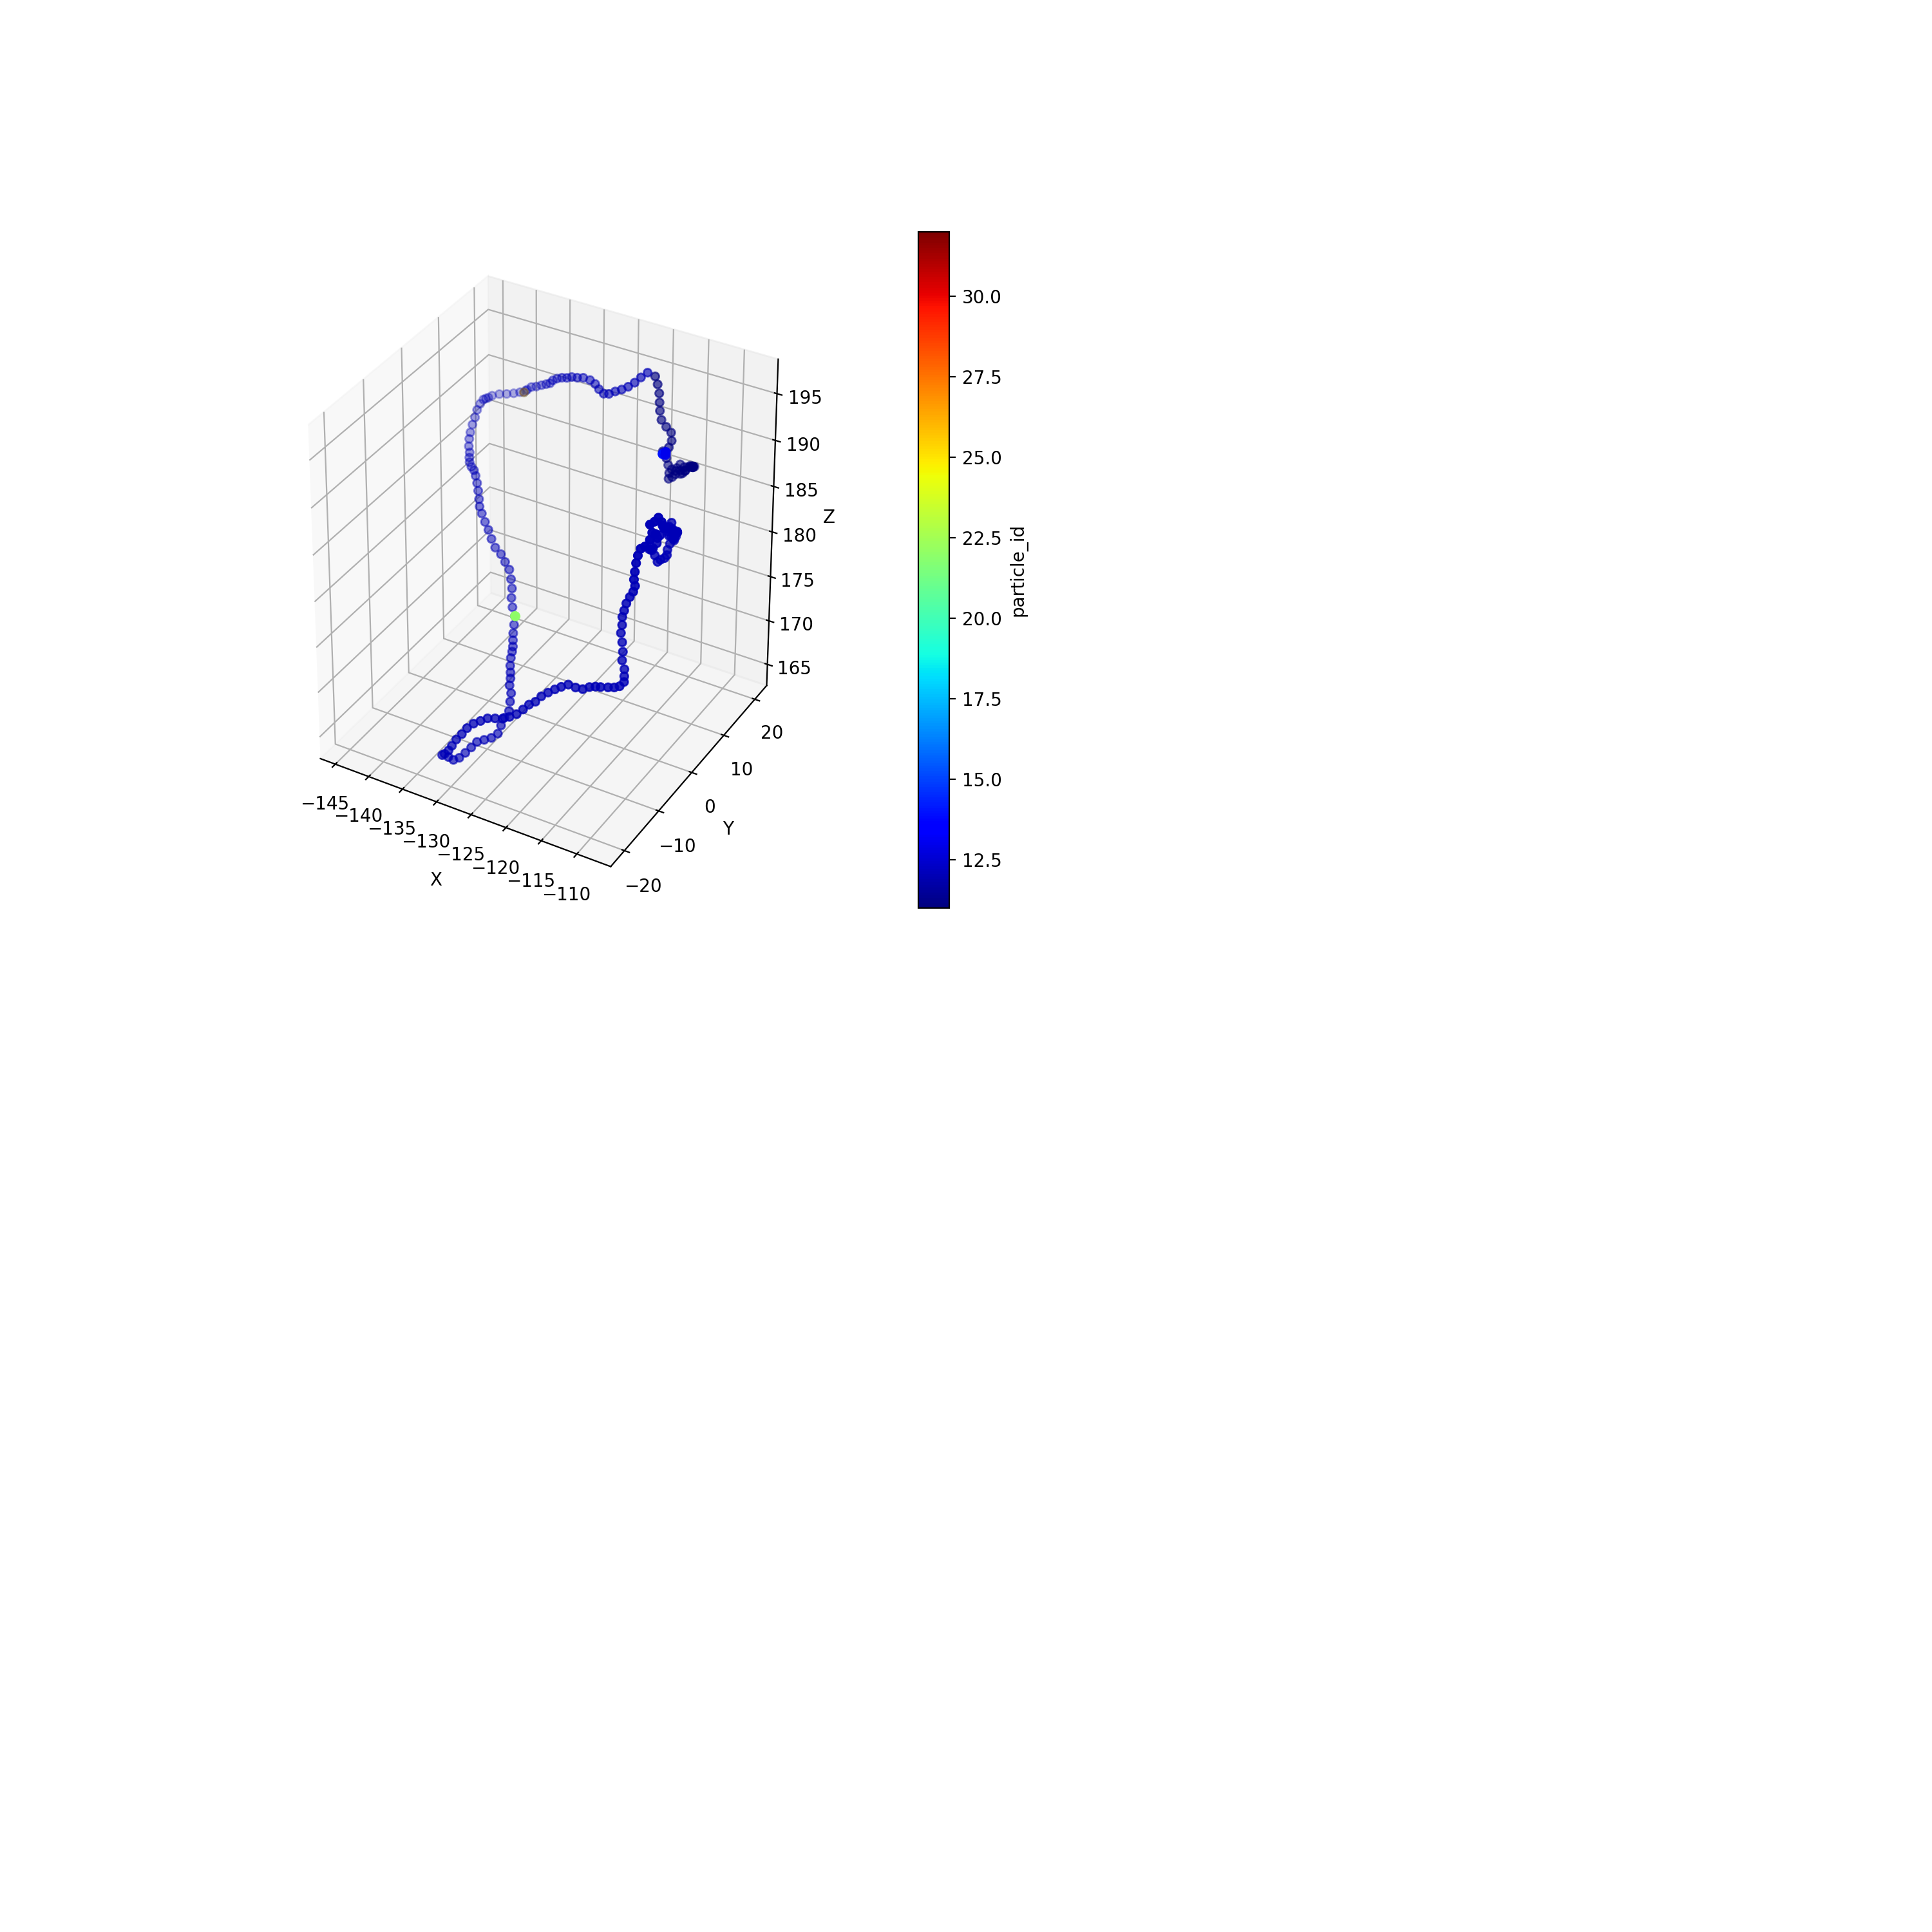

small blob = 1000


<IPython.core.display.Javascript object>


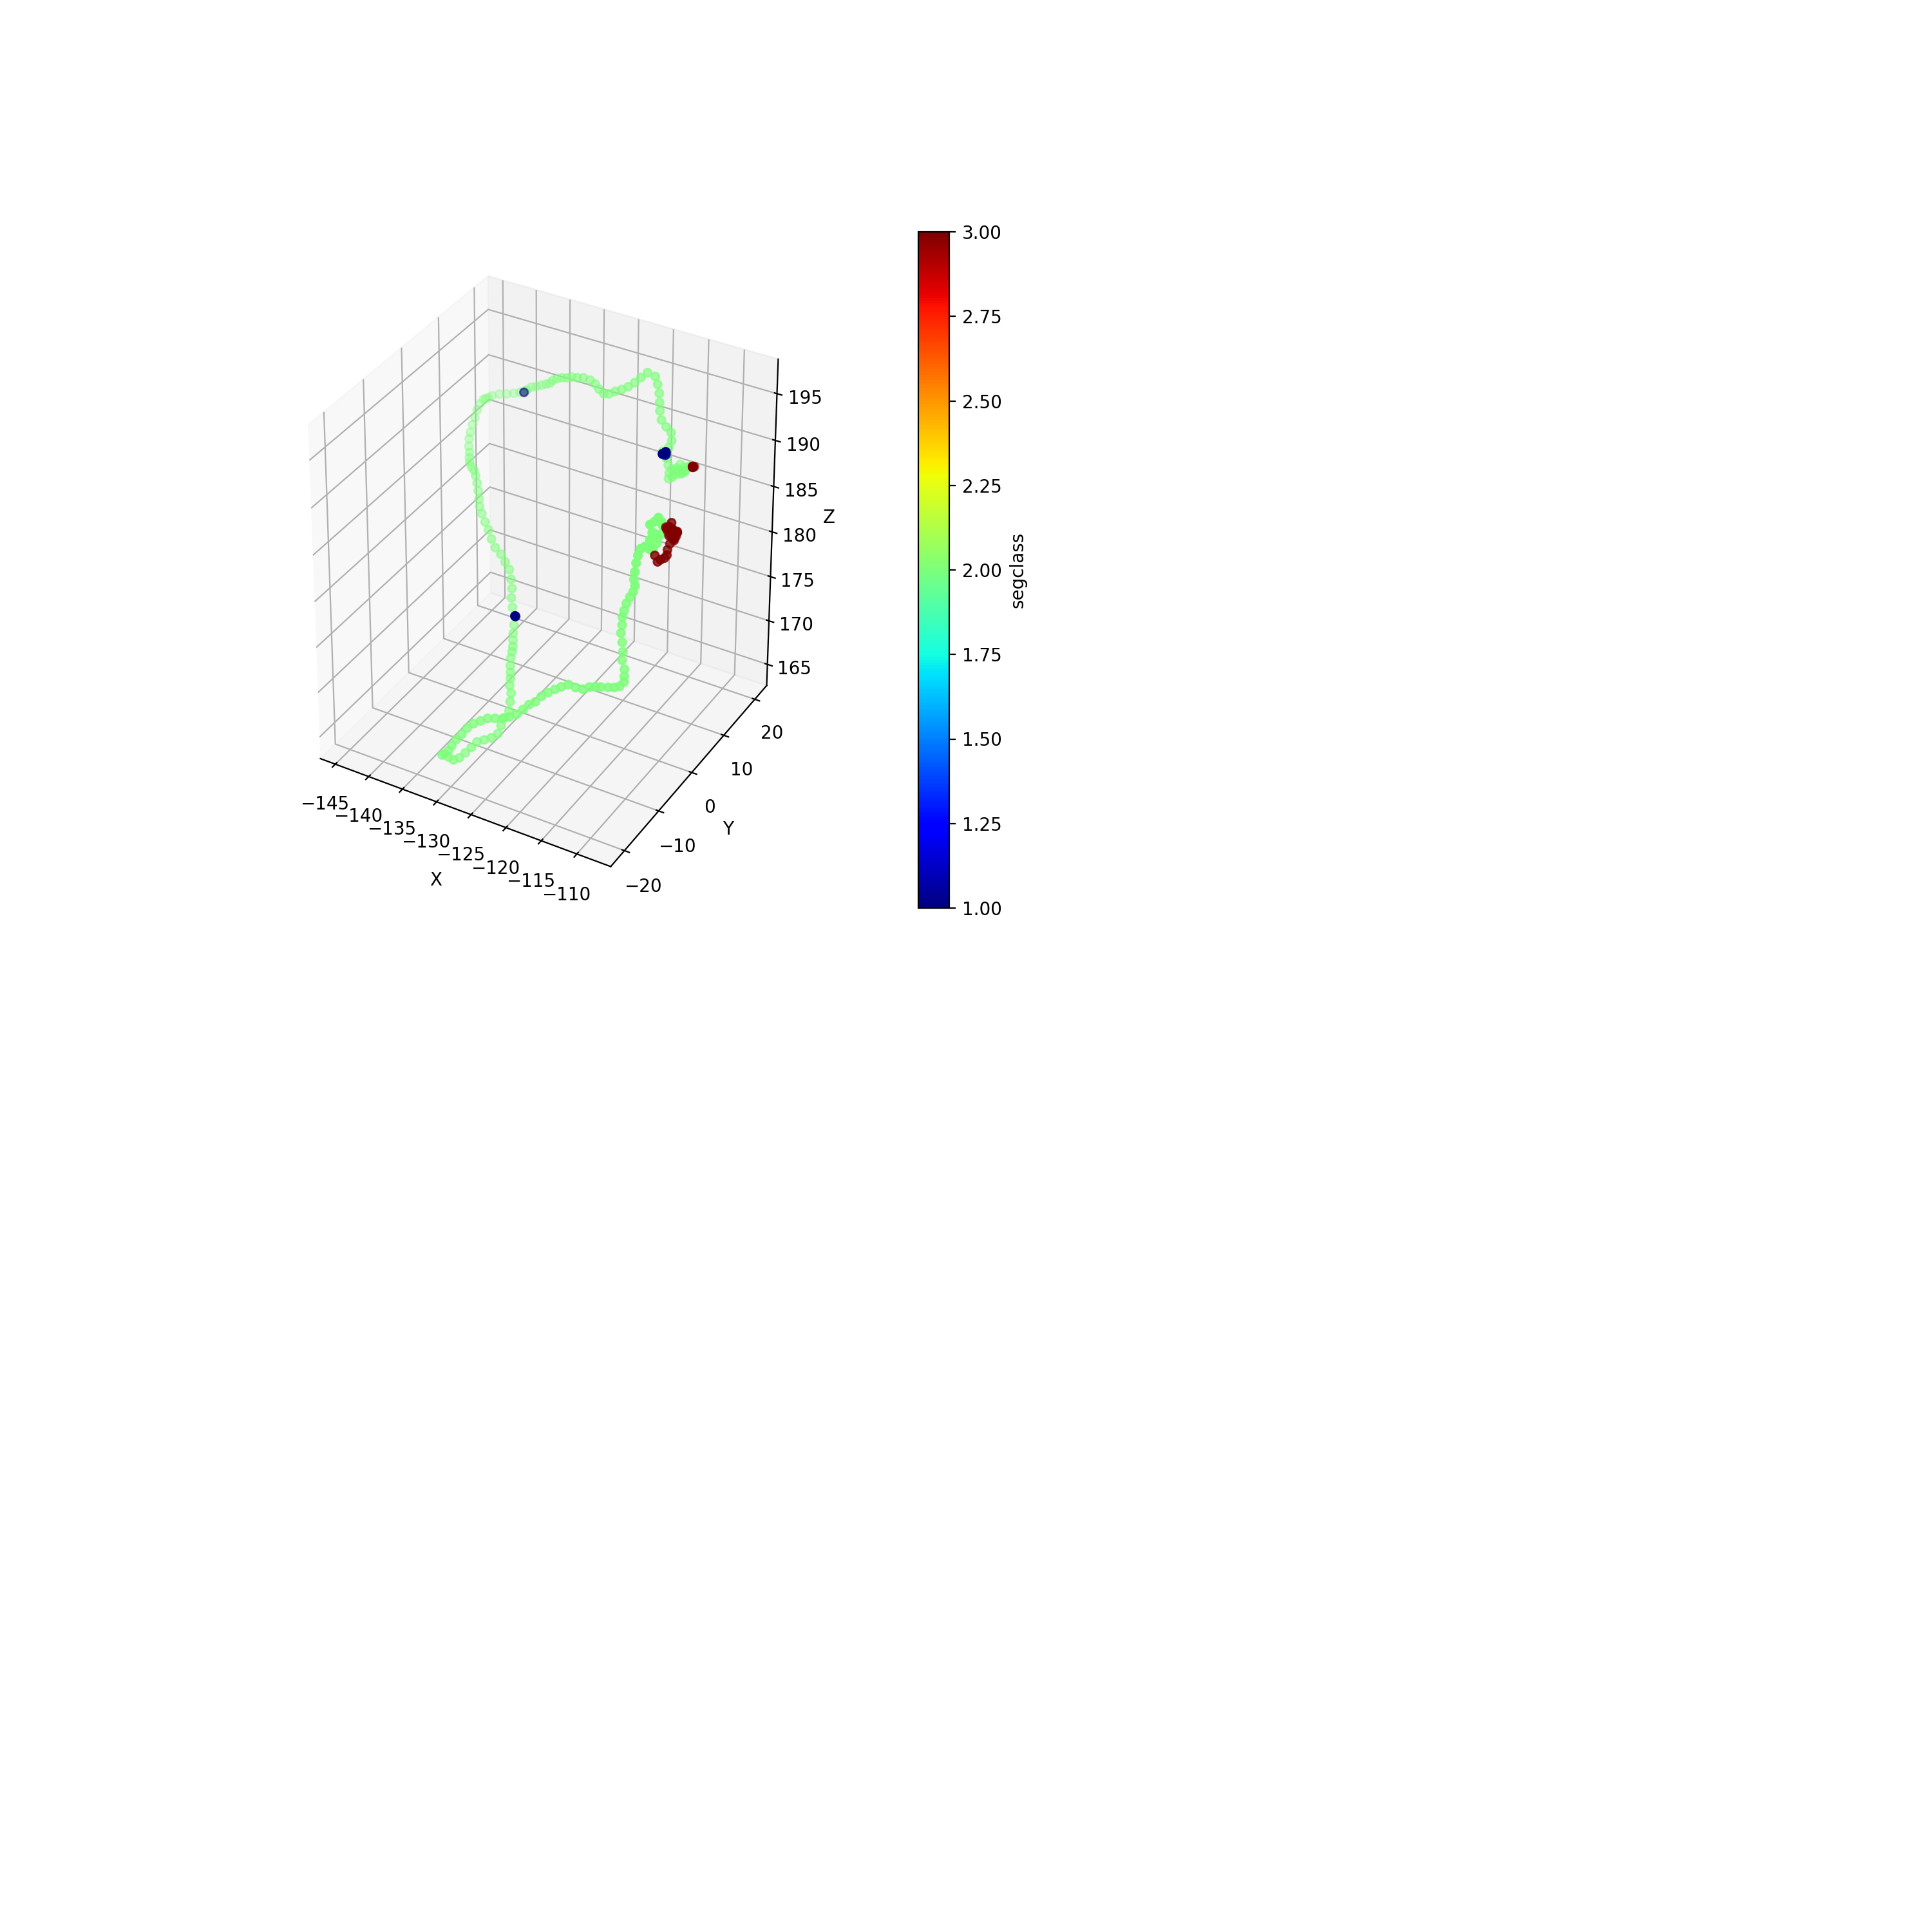

small blob = 1.5


<IPython.core.display.Javascript object>


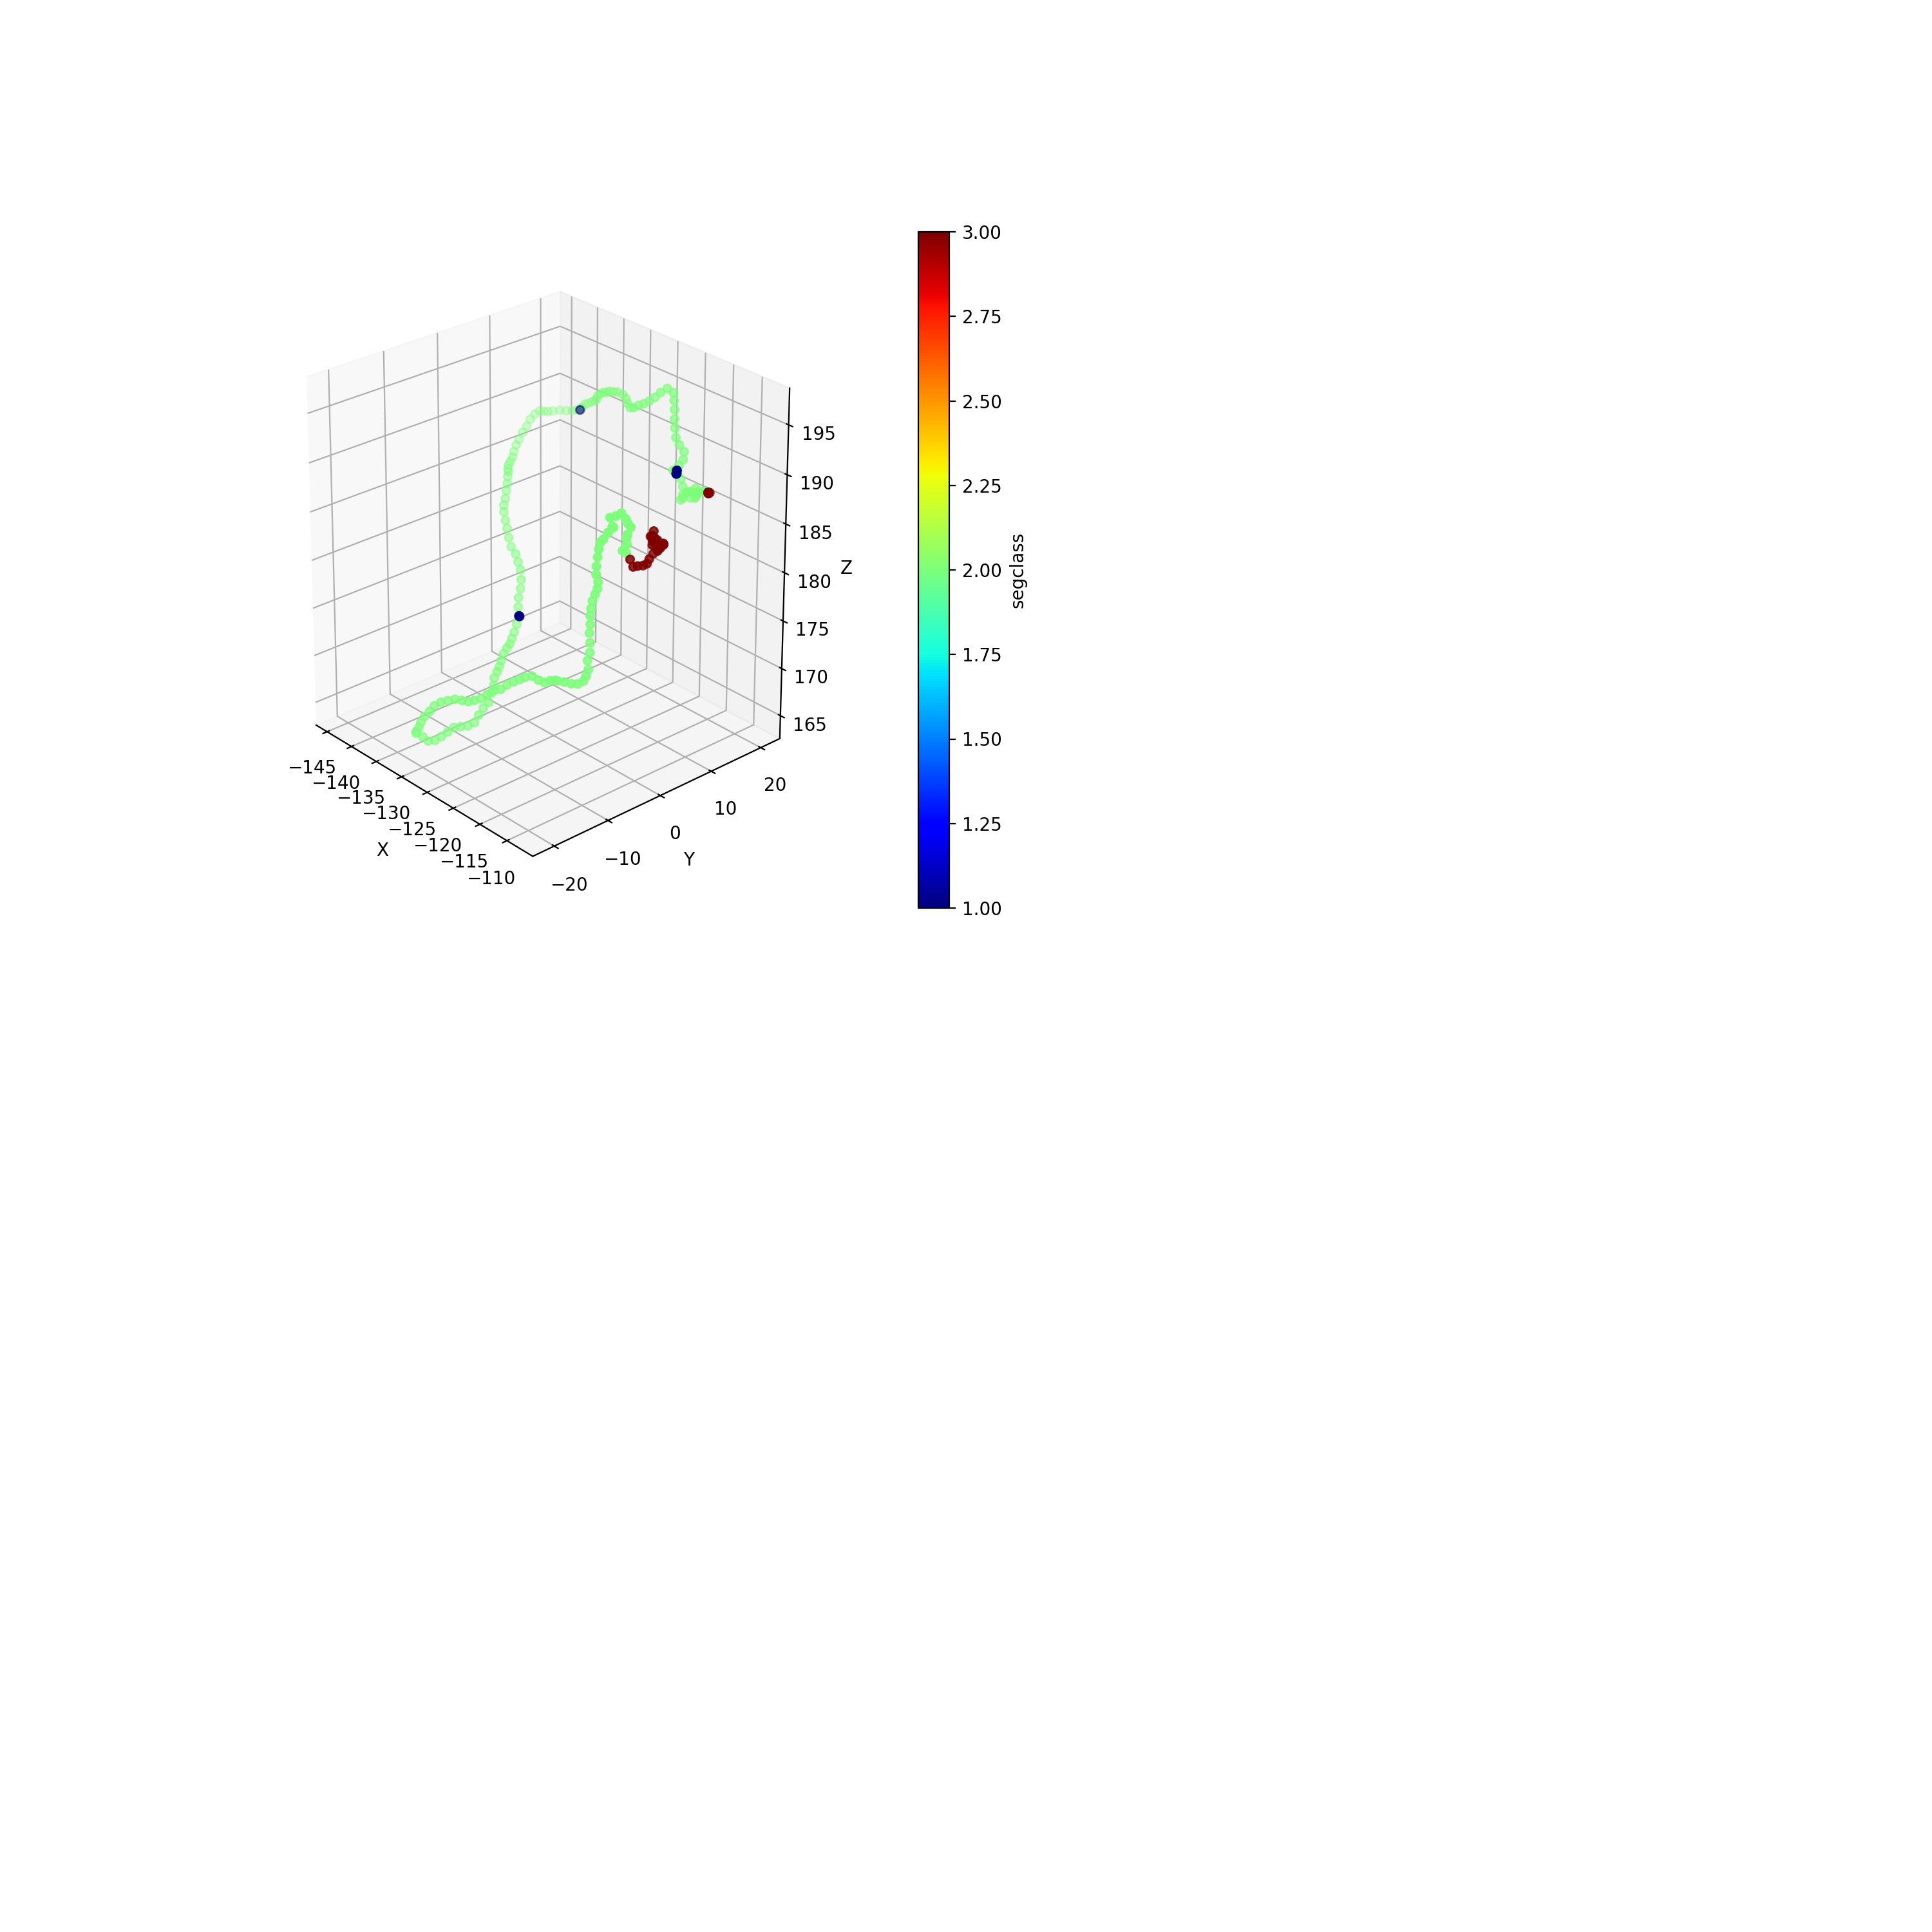

small blob = 1000


<IPython.core.display.Javascript object>


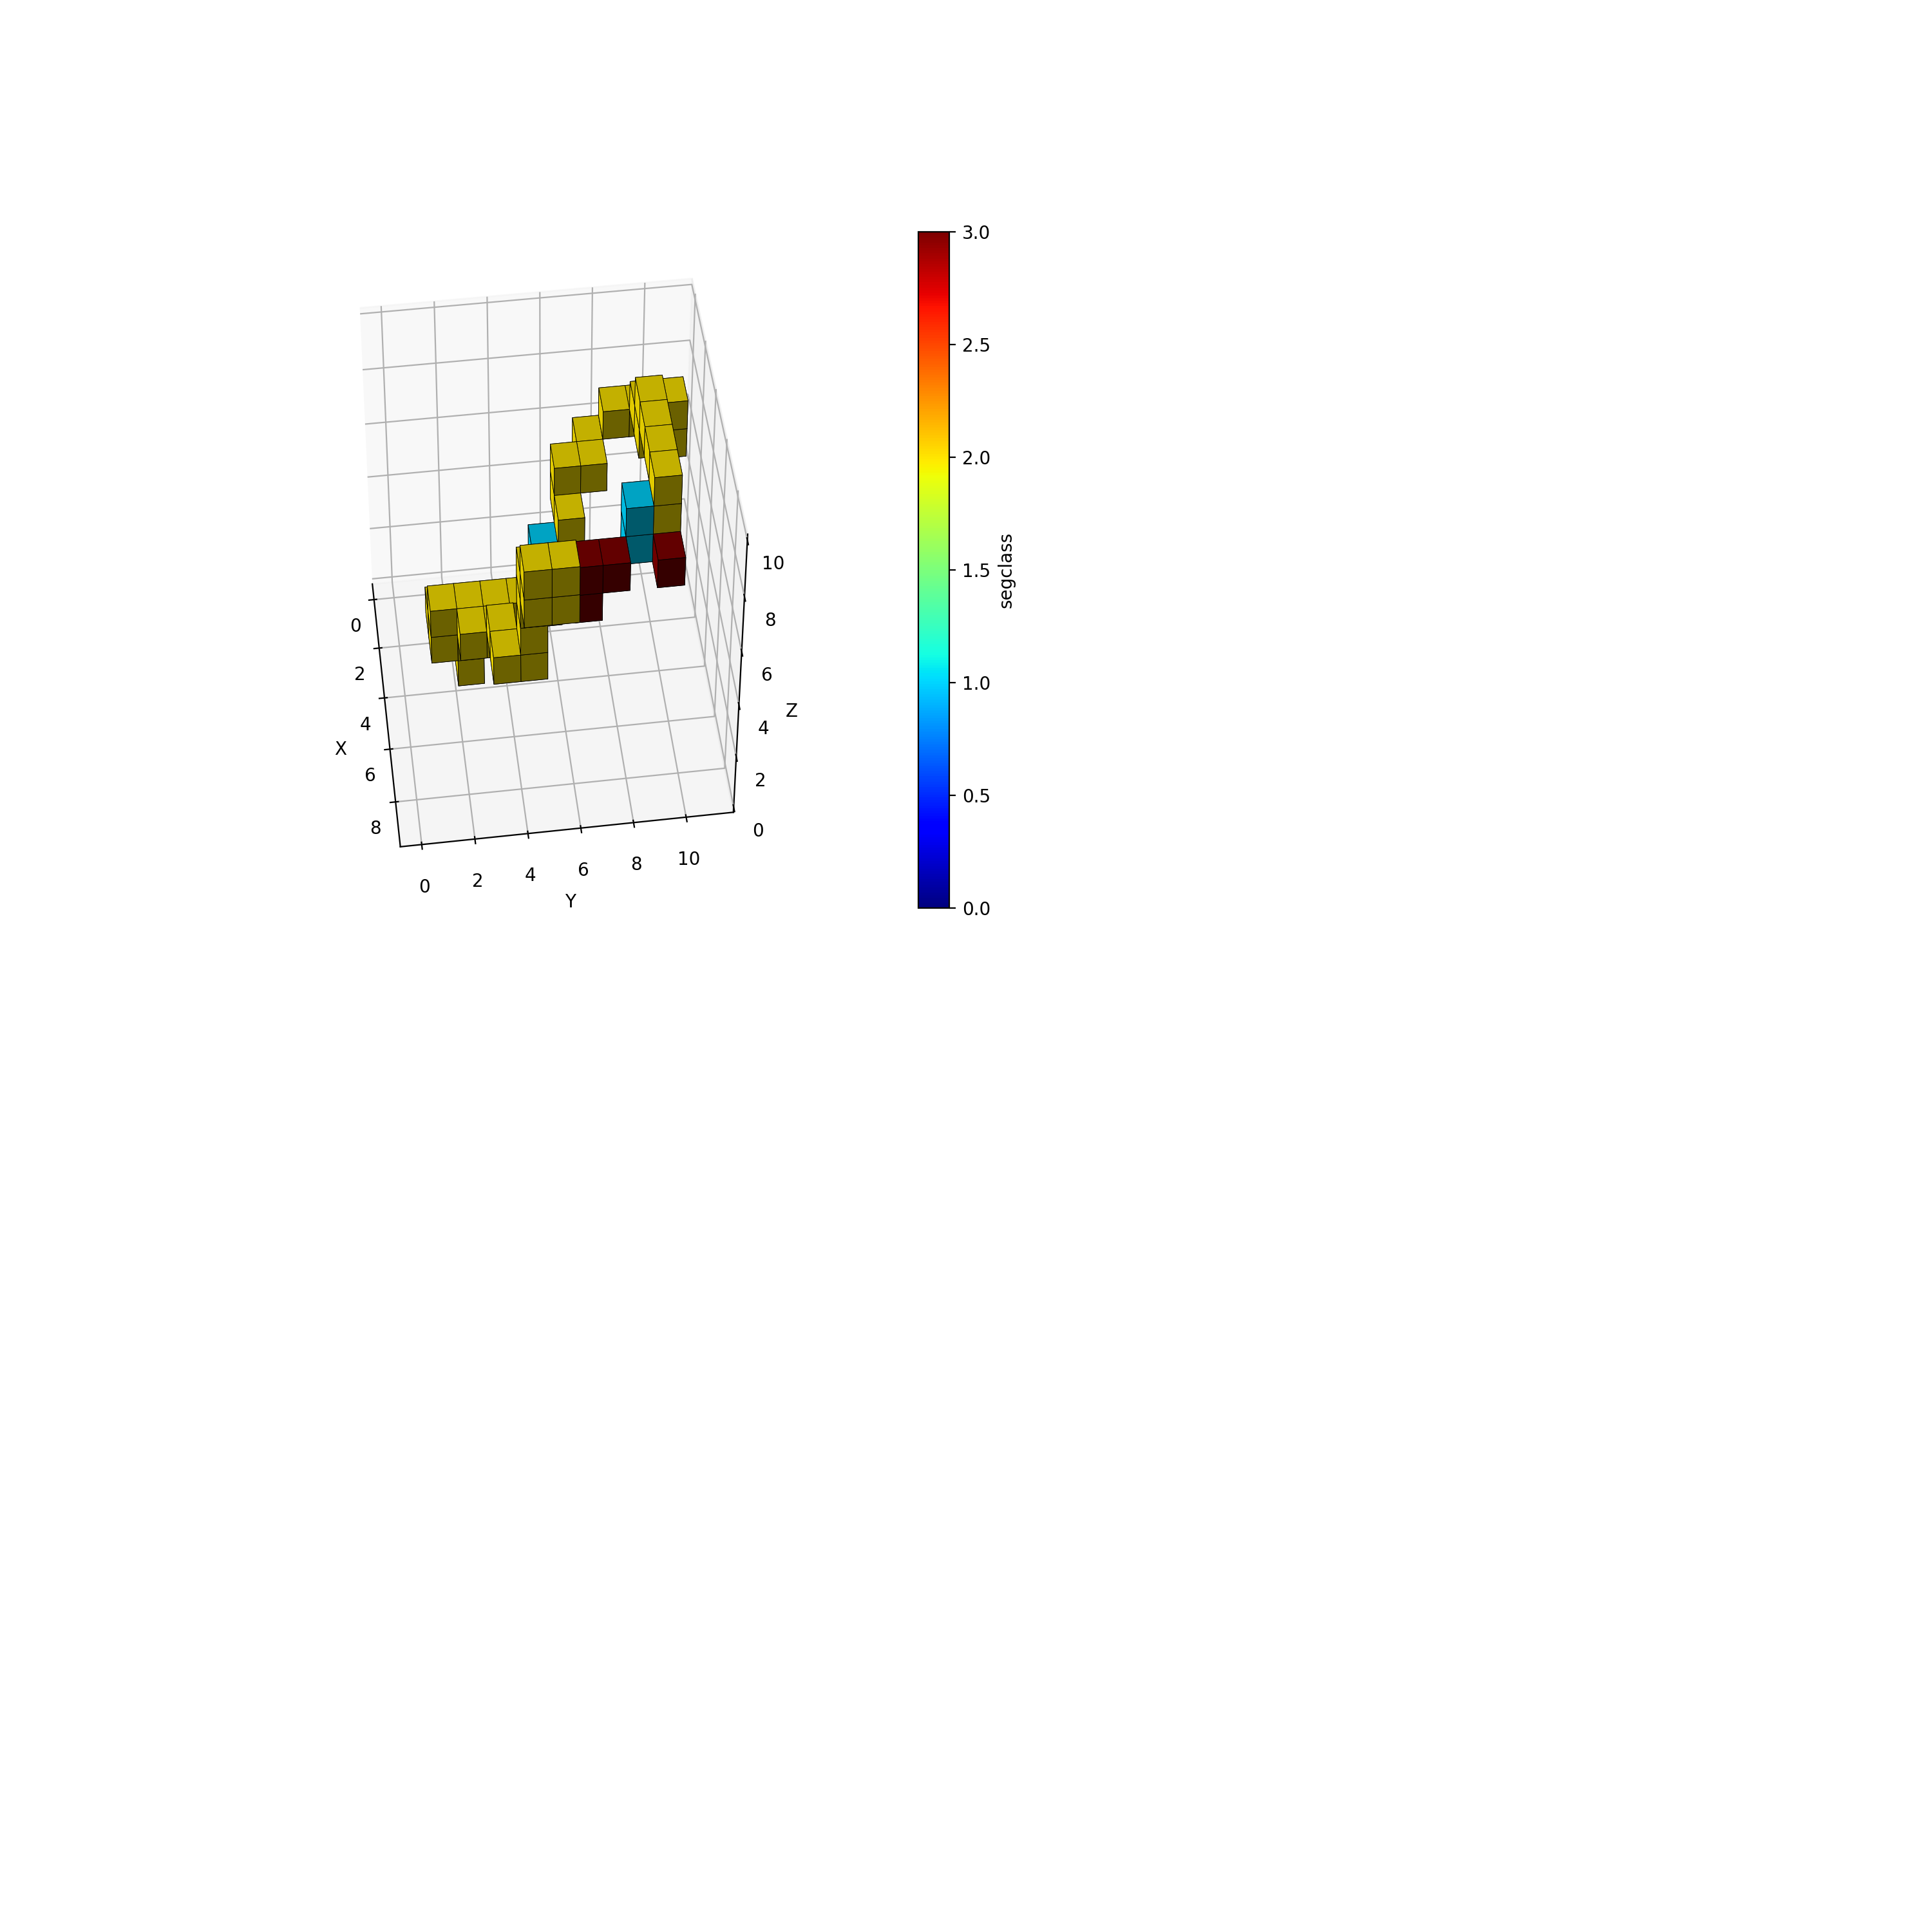

small blob = 1.5


<IPython.core.display.Javascript object>


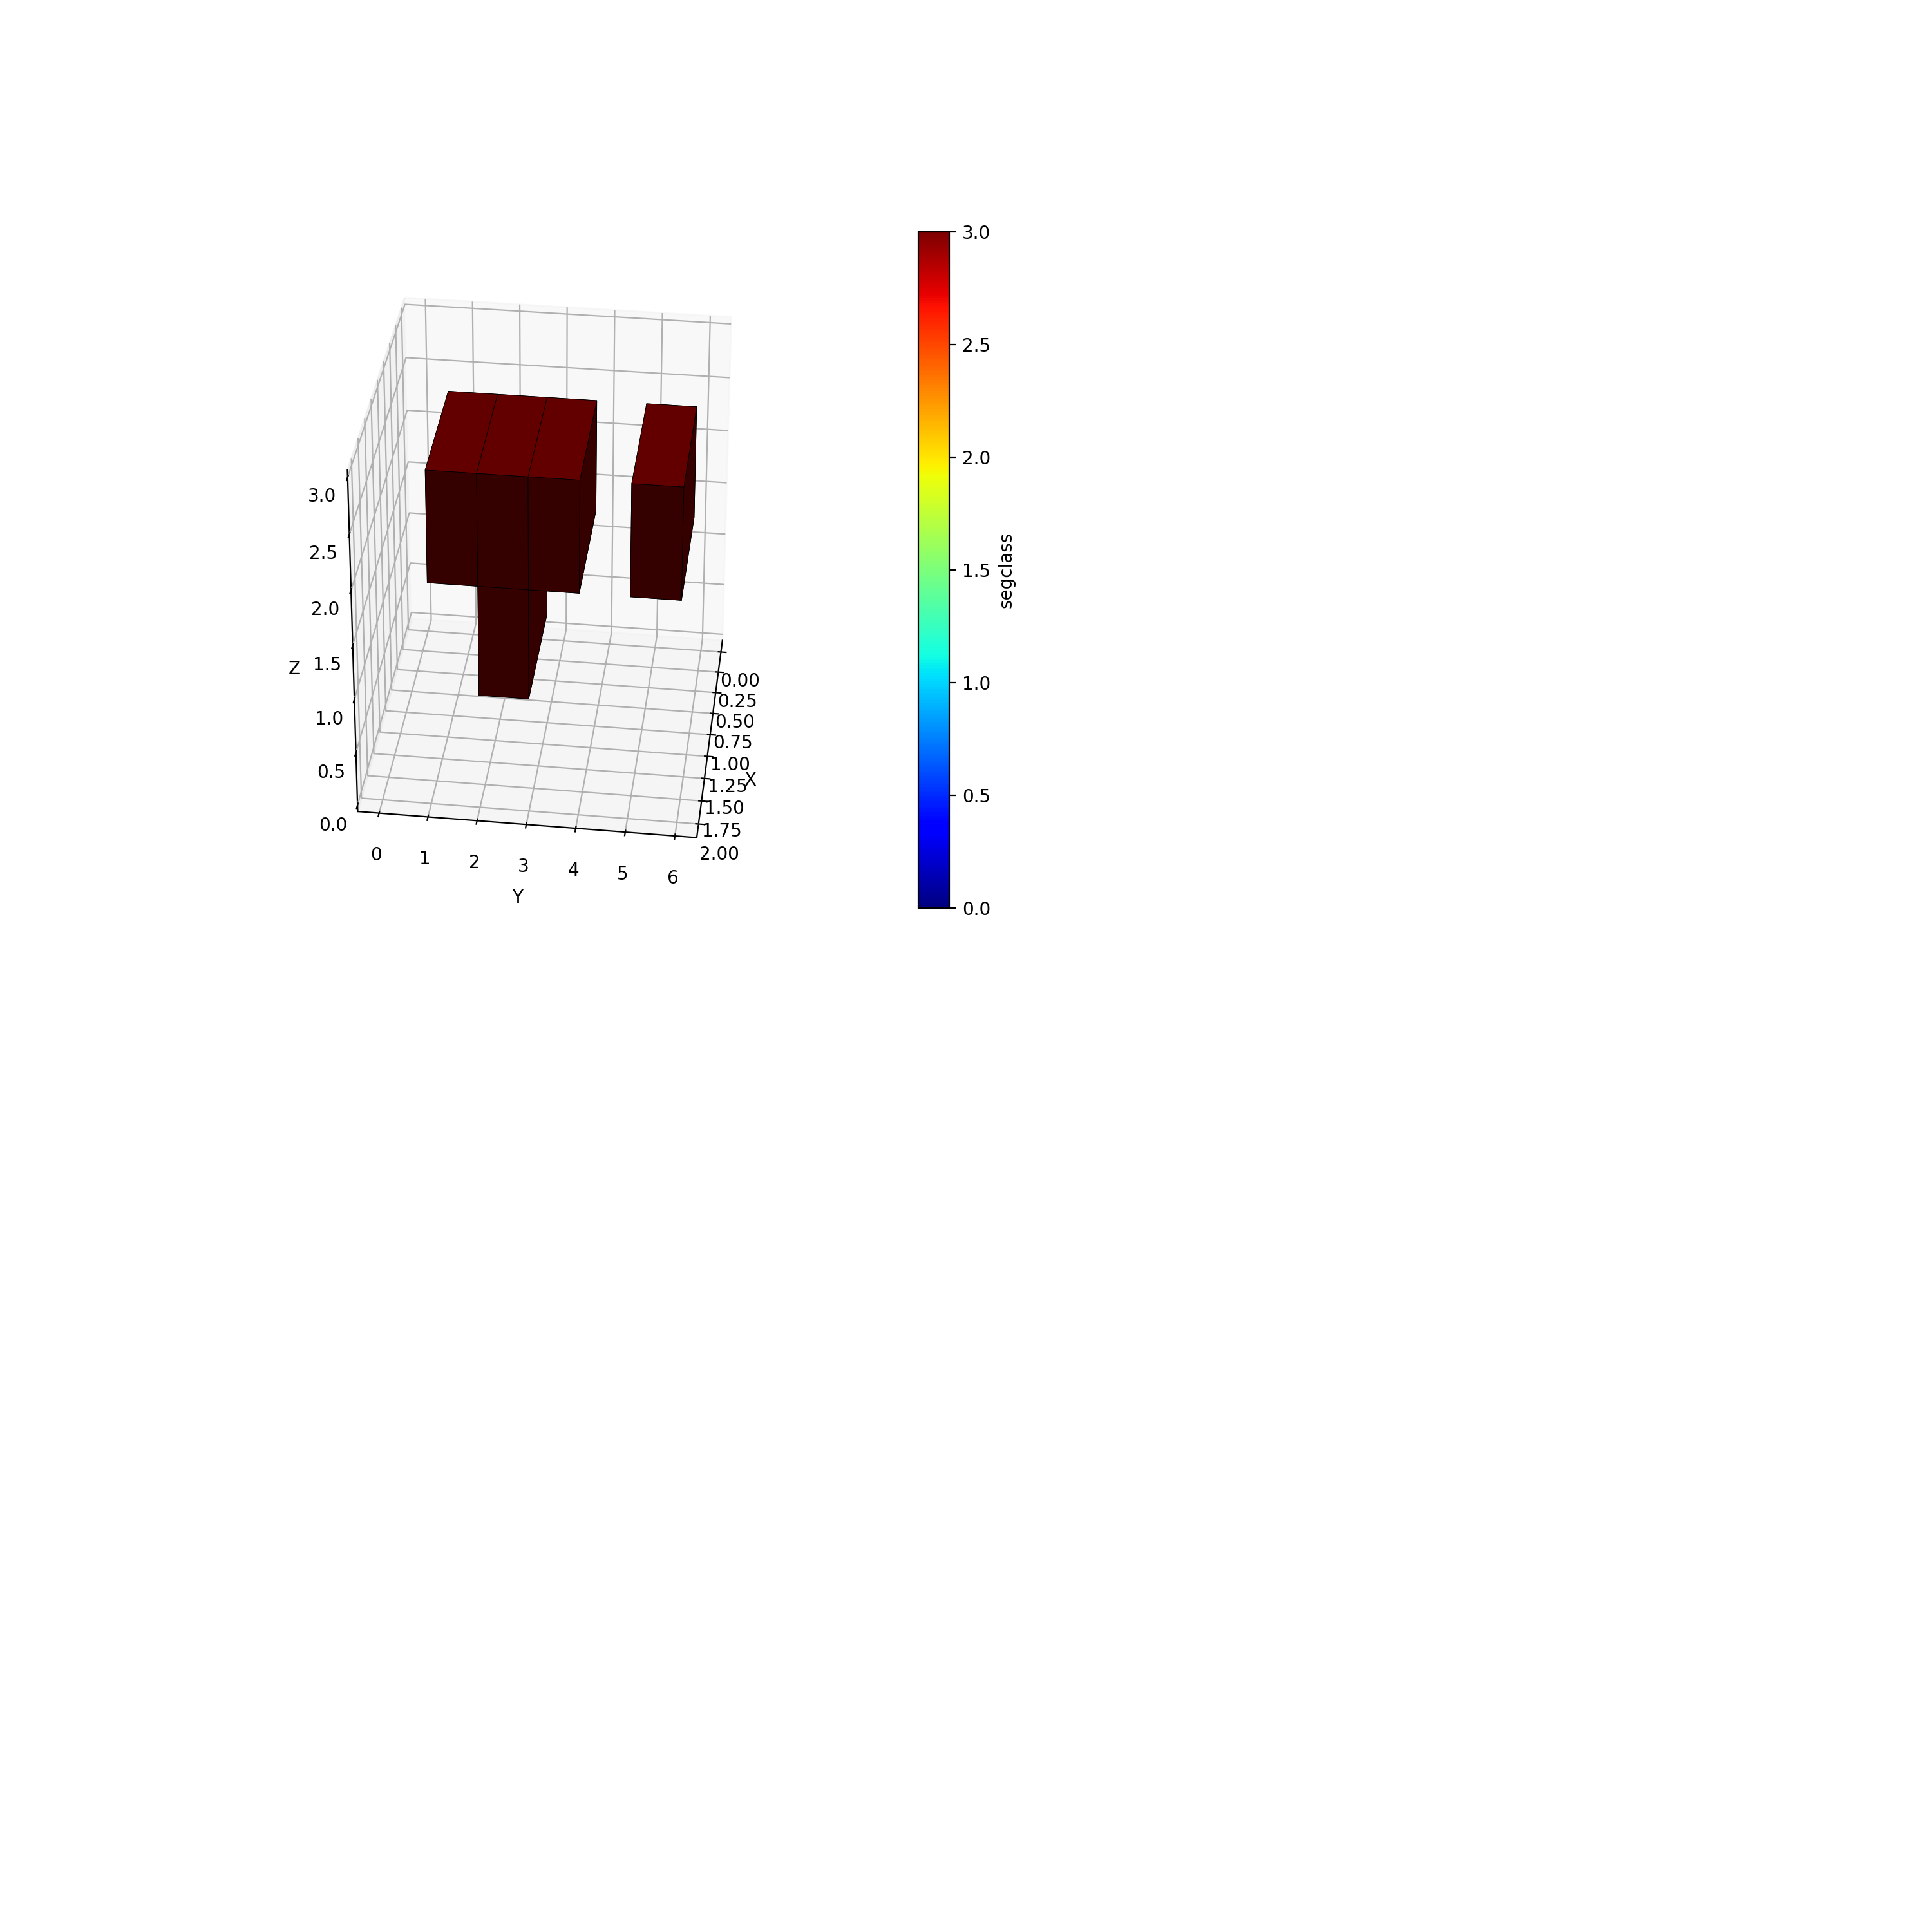

<IPython.core.display.Javascript object>


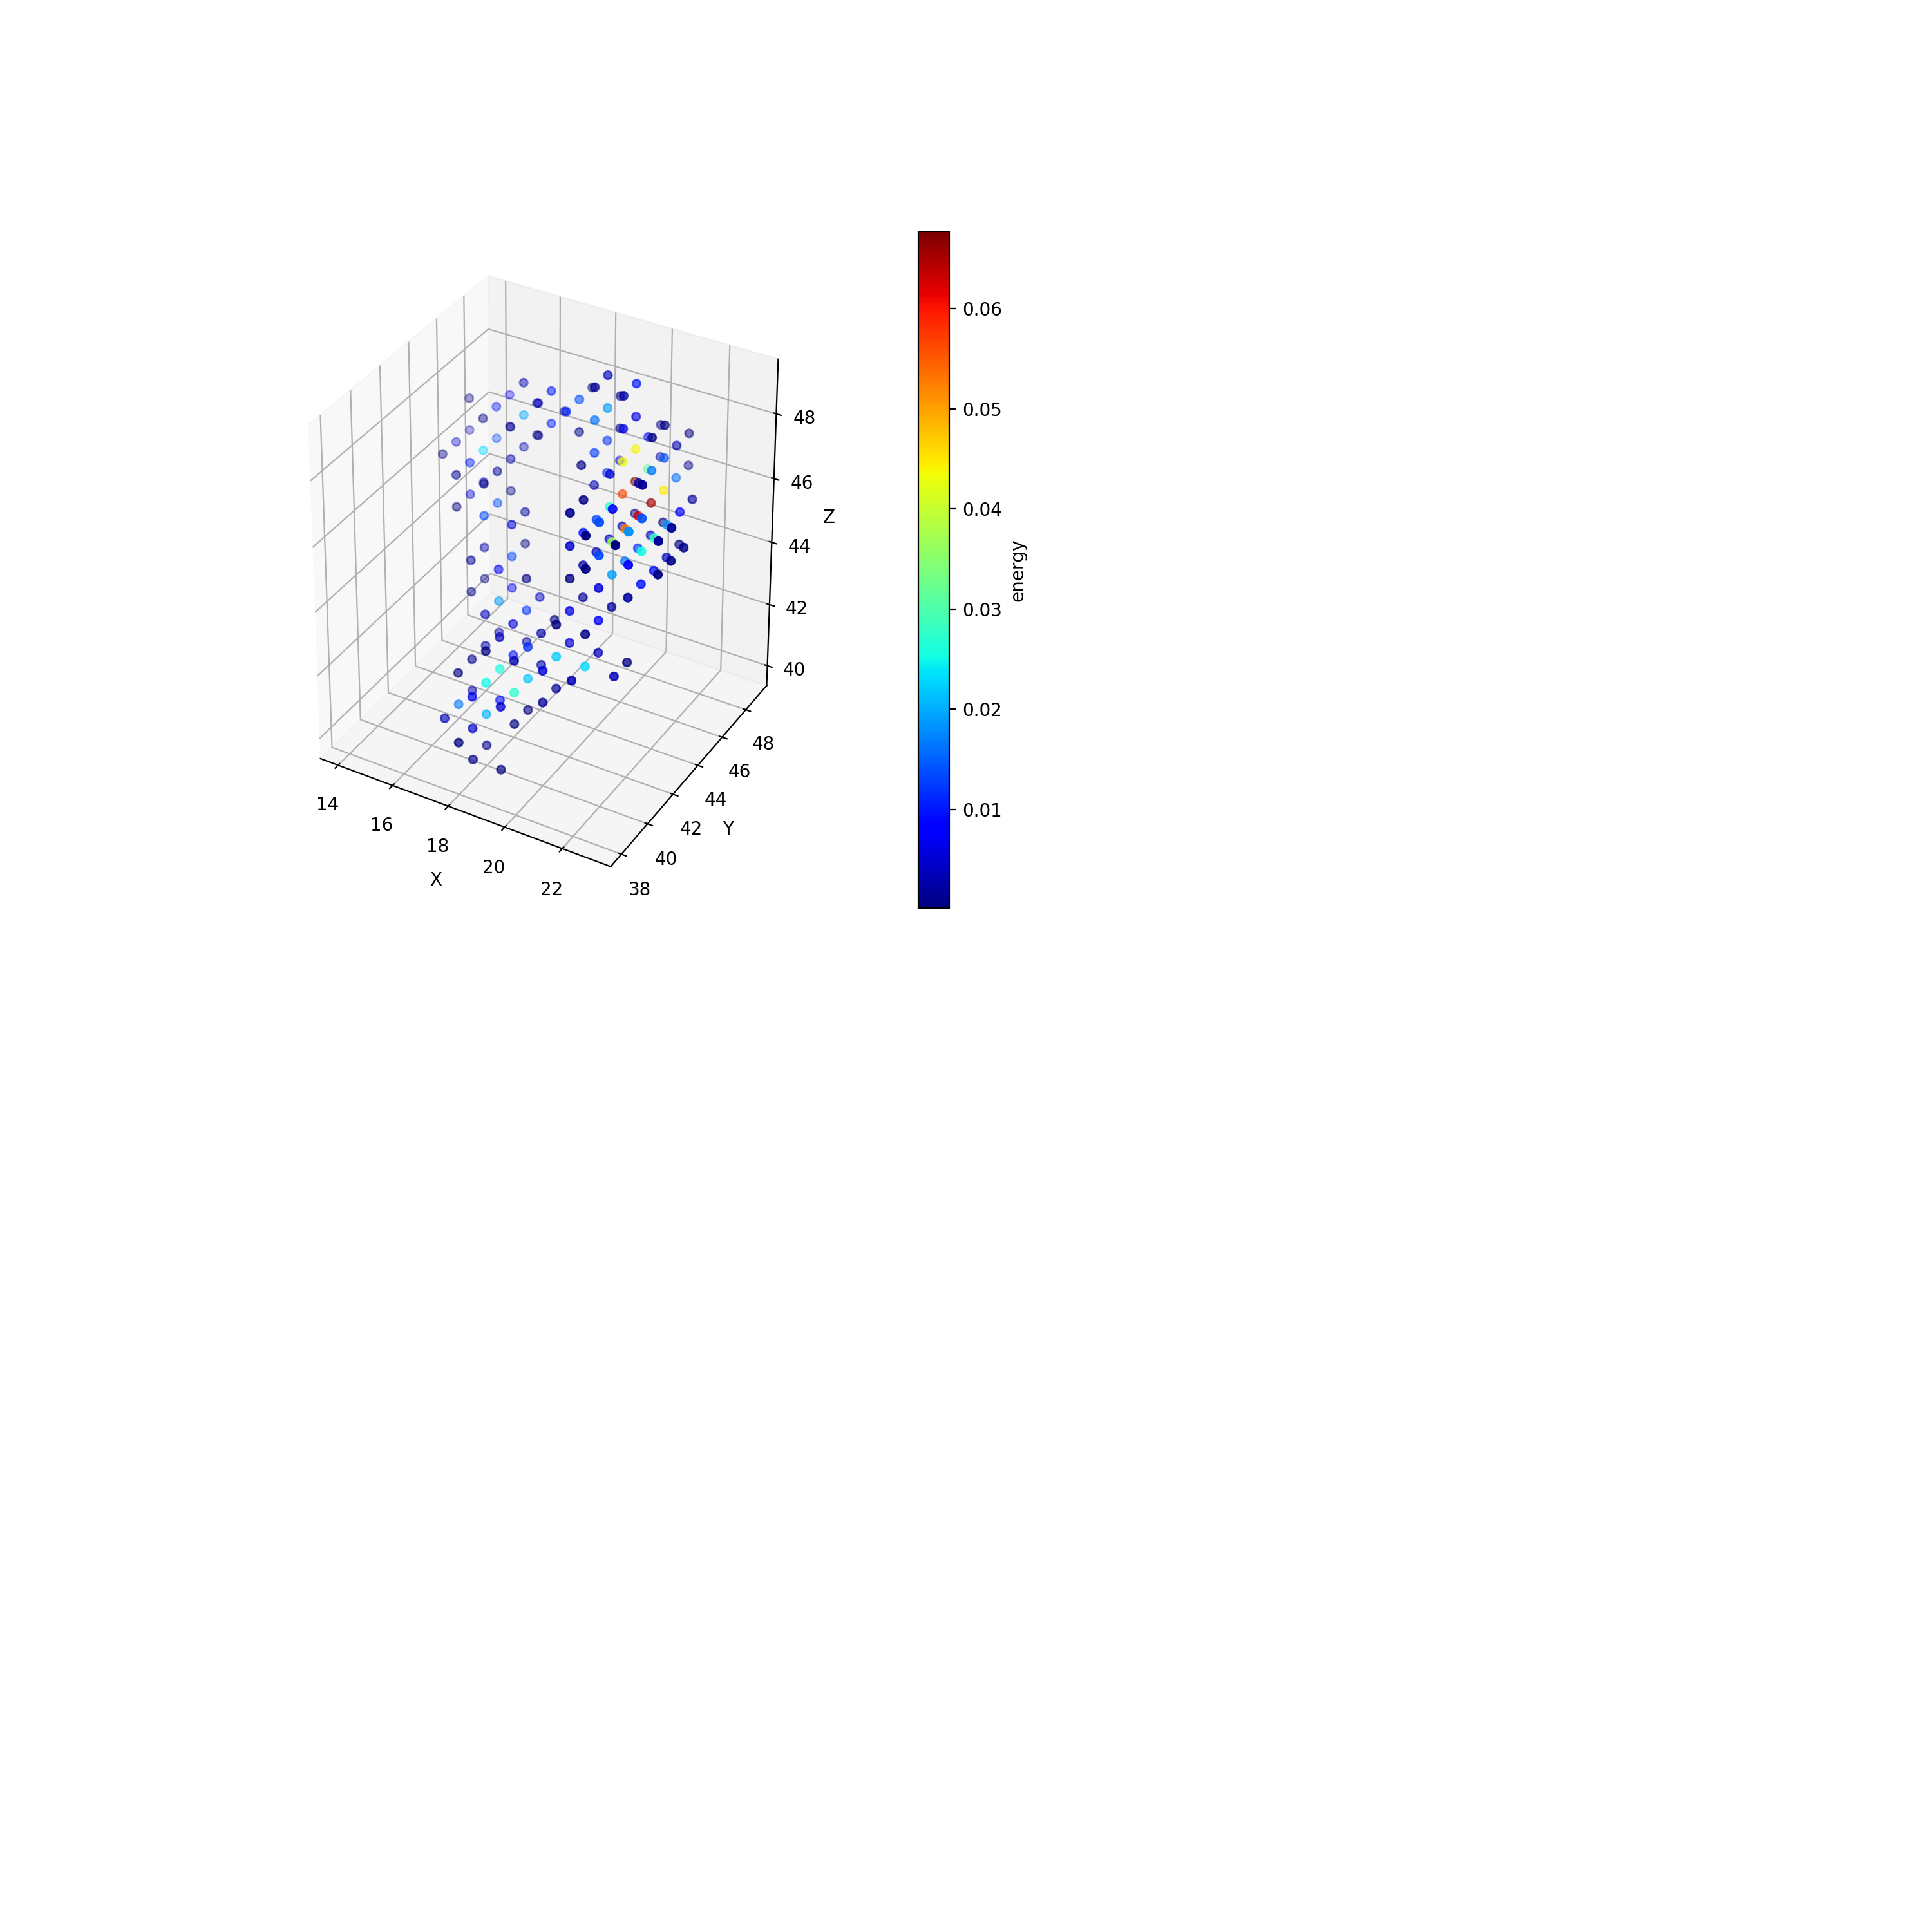

small blob = 1000


<IPython.core.display.Javascript object>


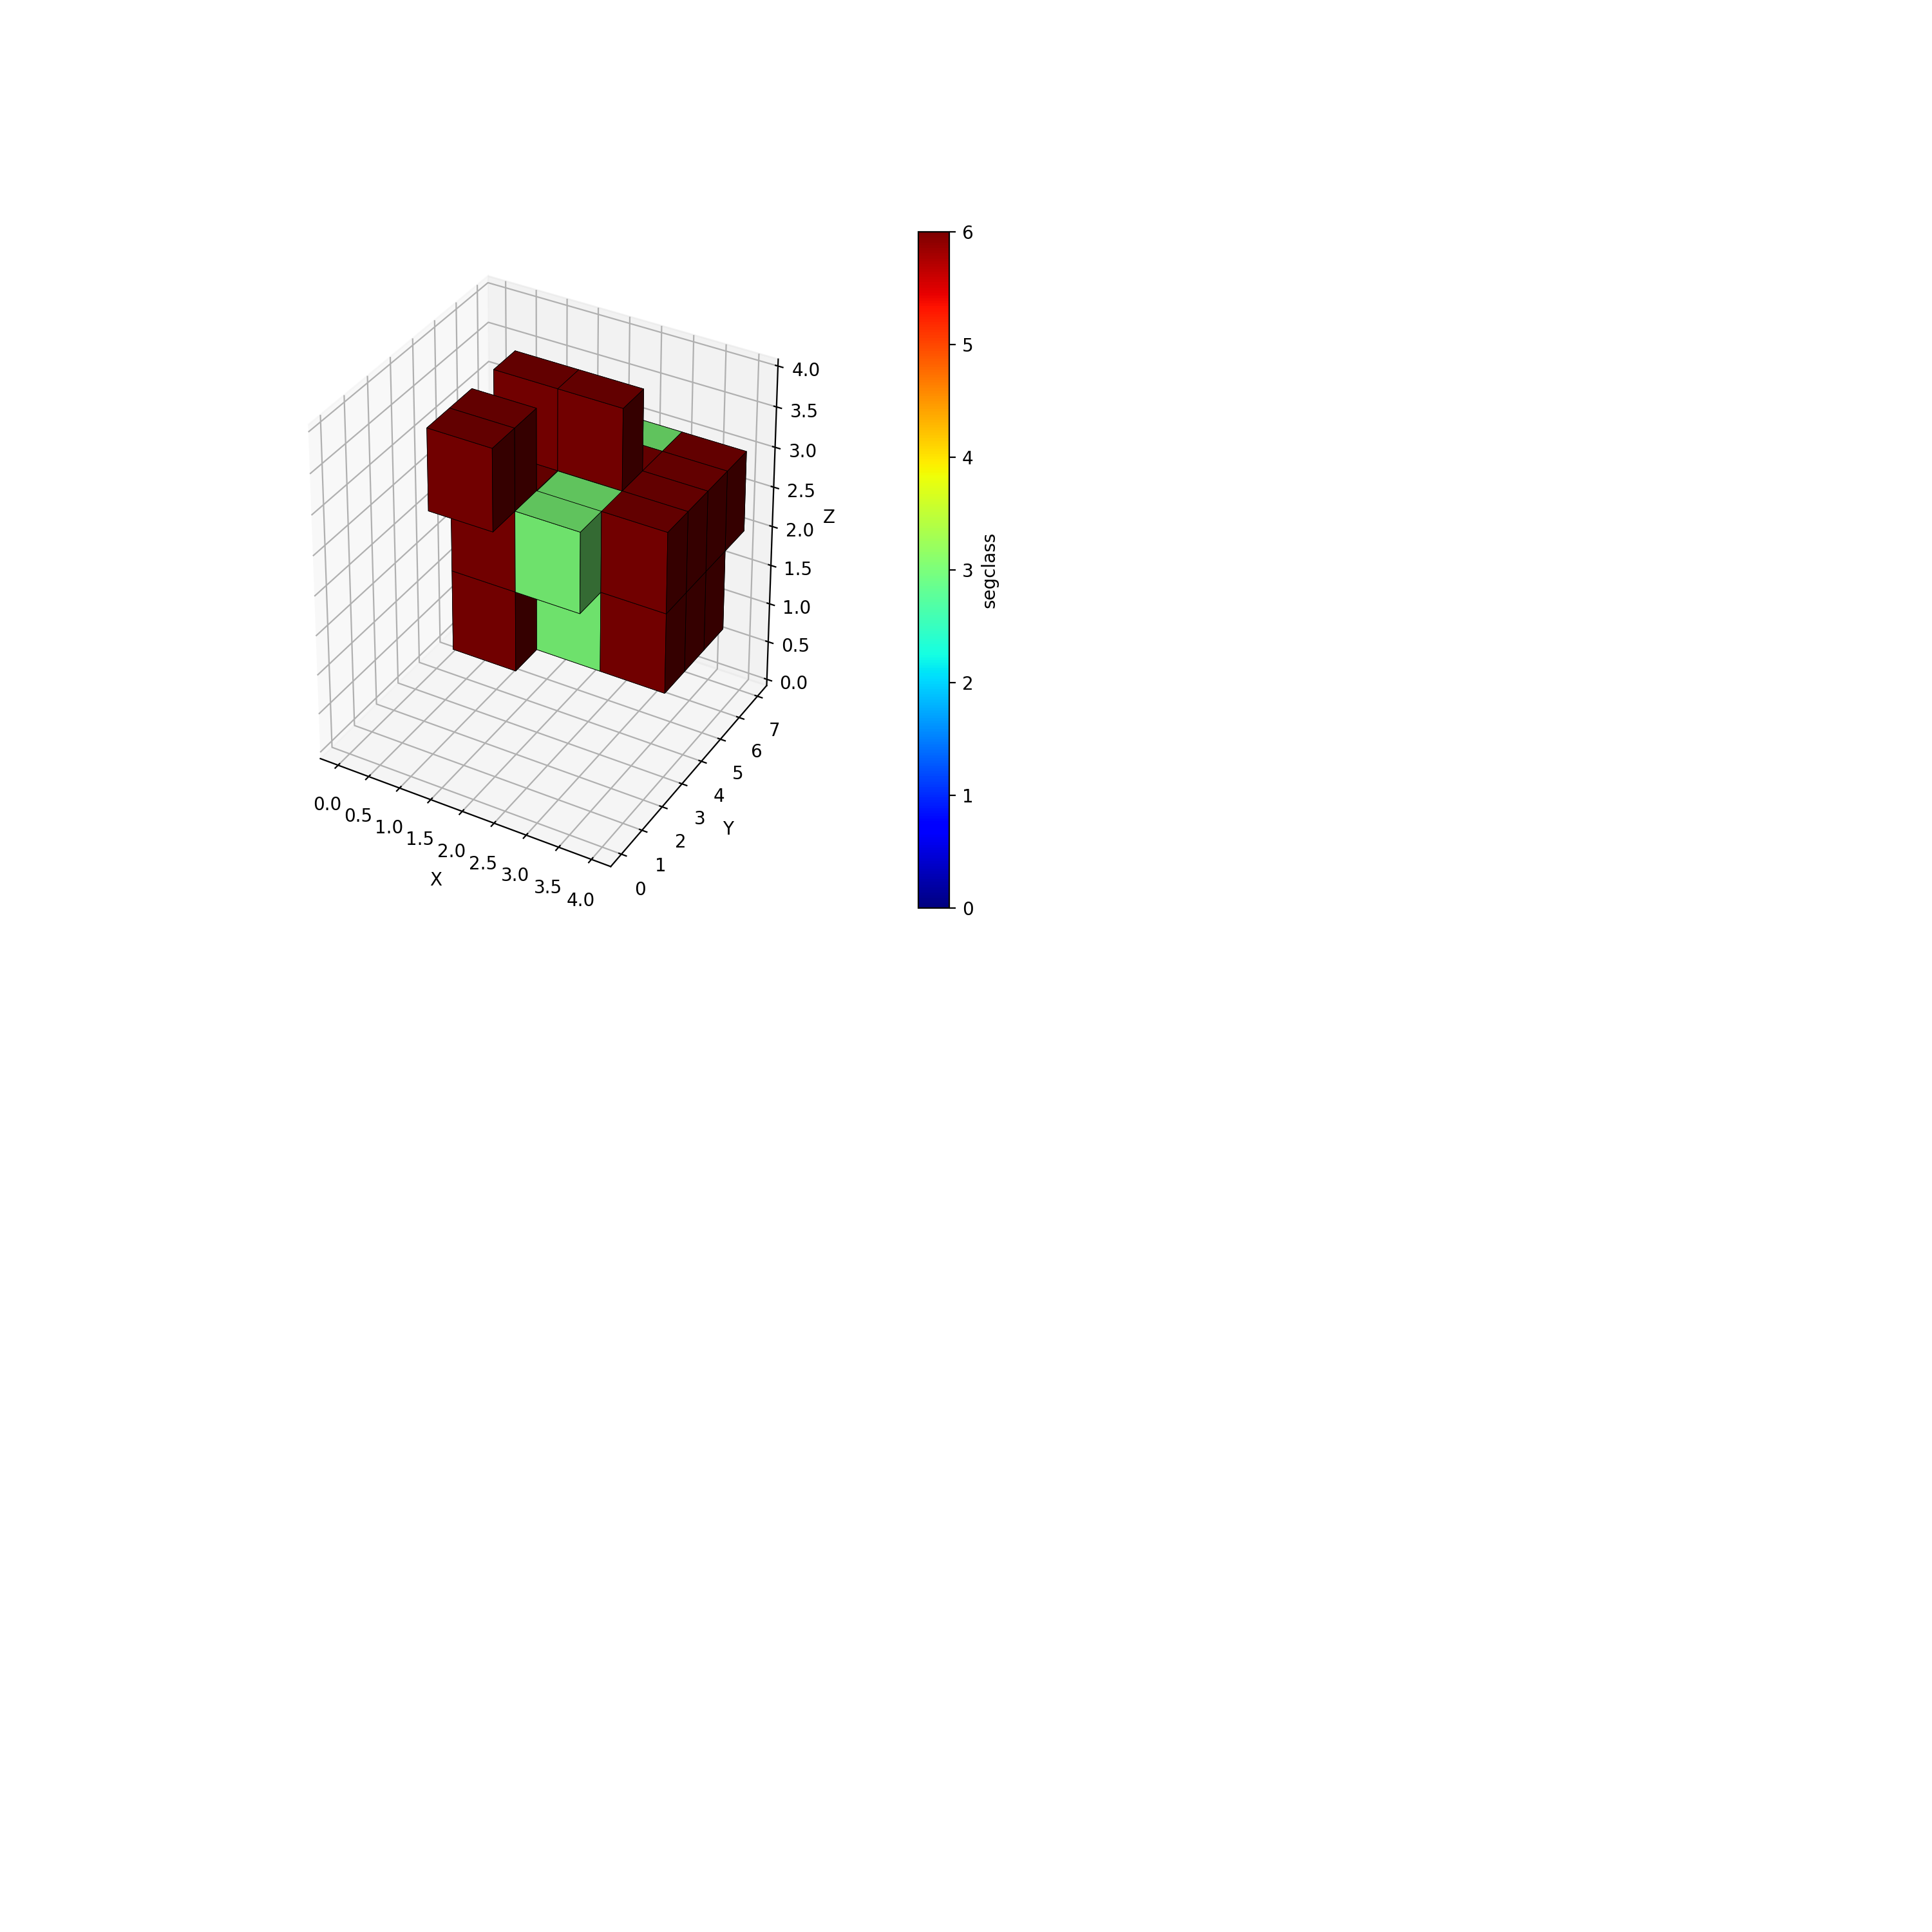

small blob = 1.5


<IPython.core.display.Javascript object>


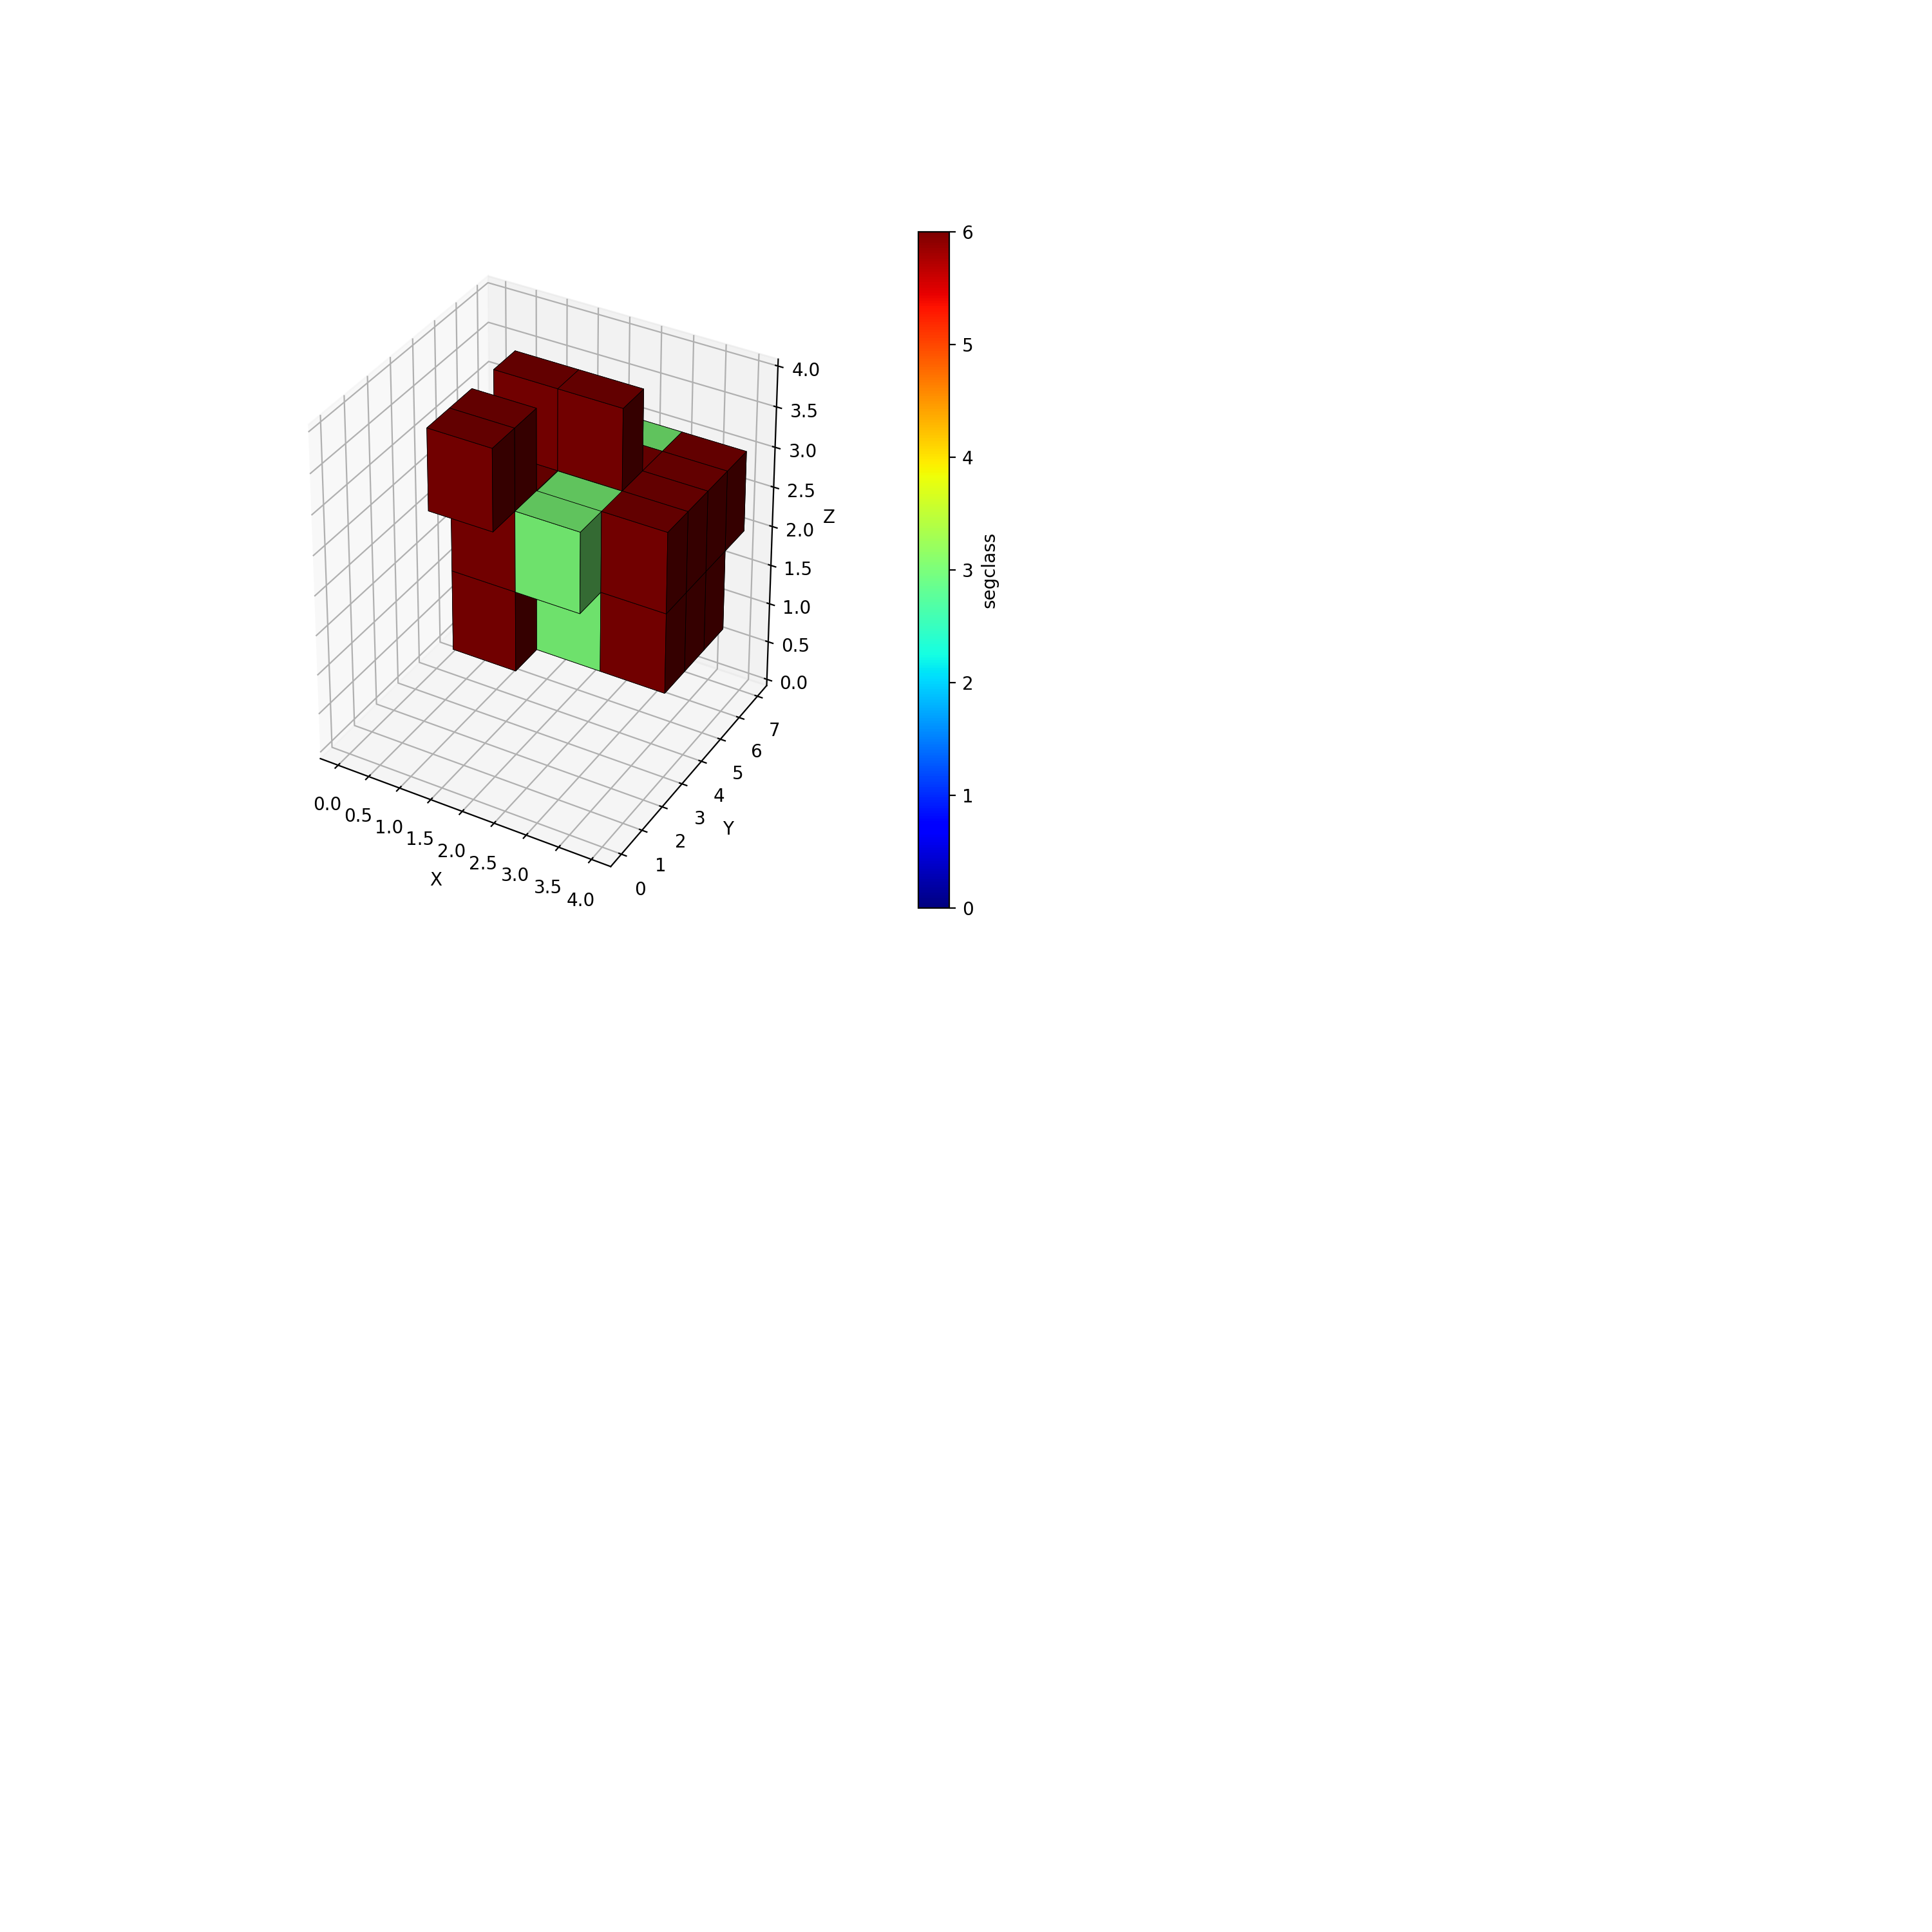

<IPython.core.display.Javascript object>


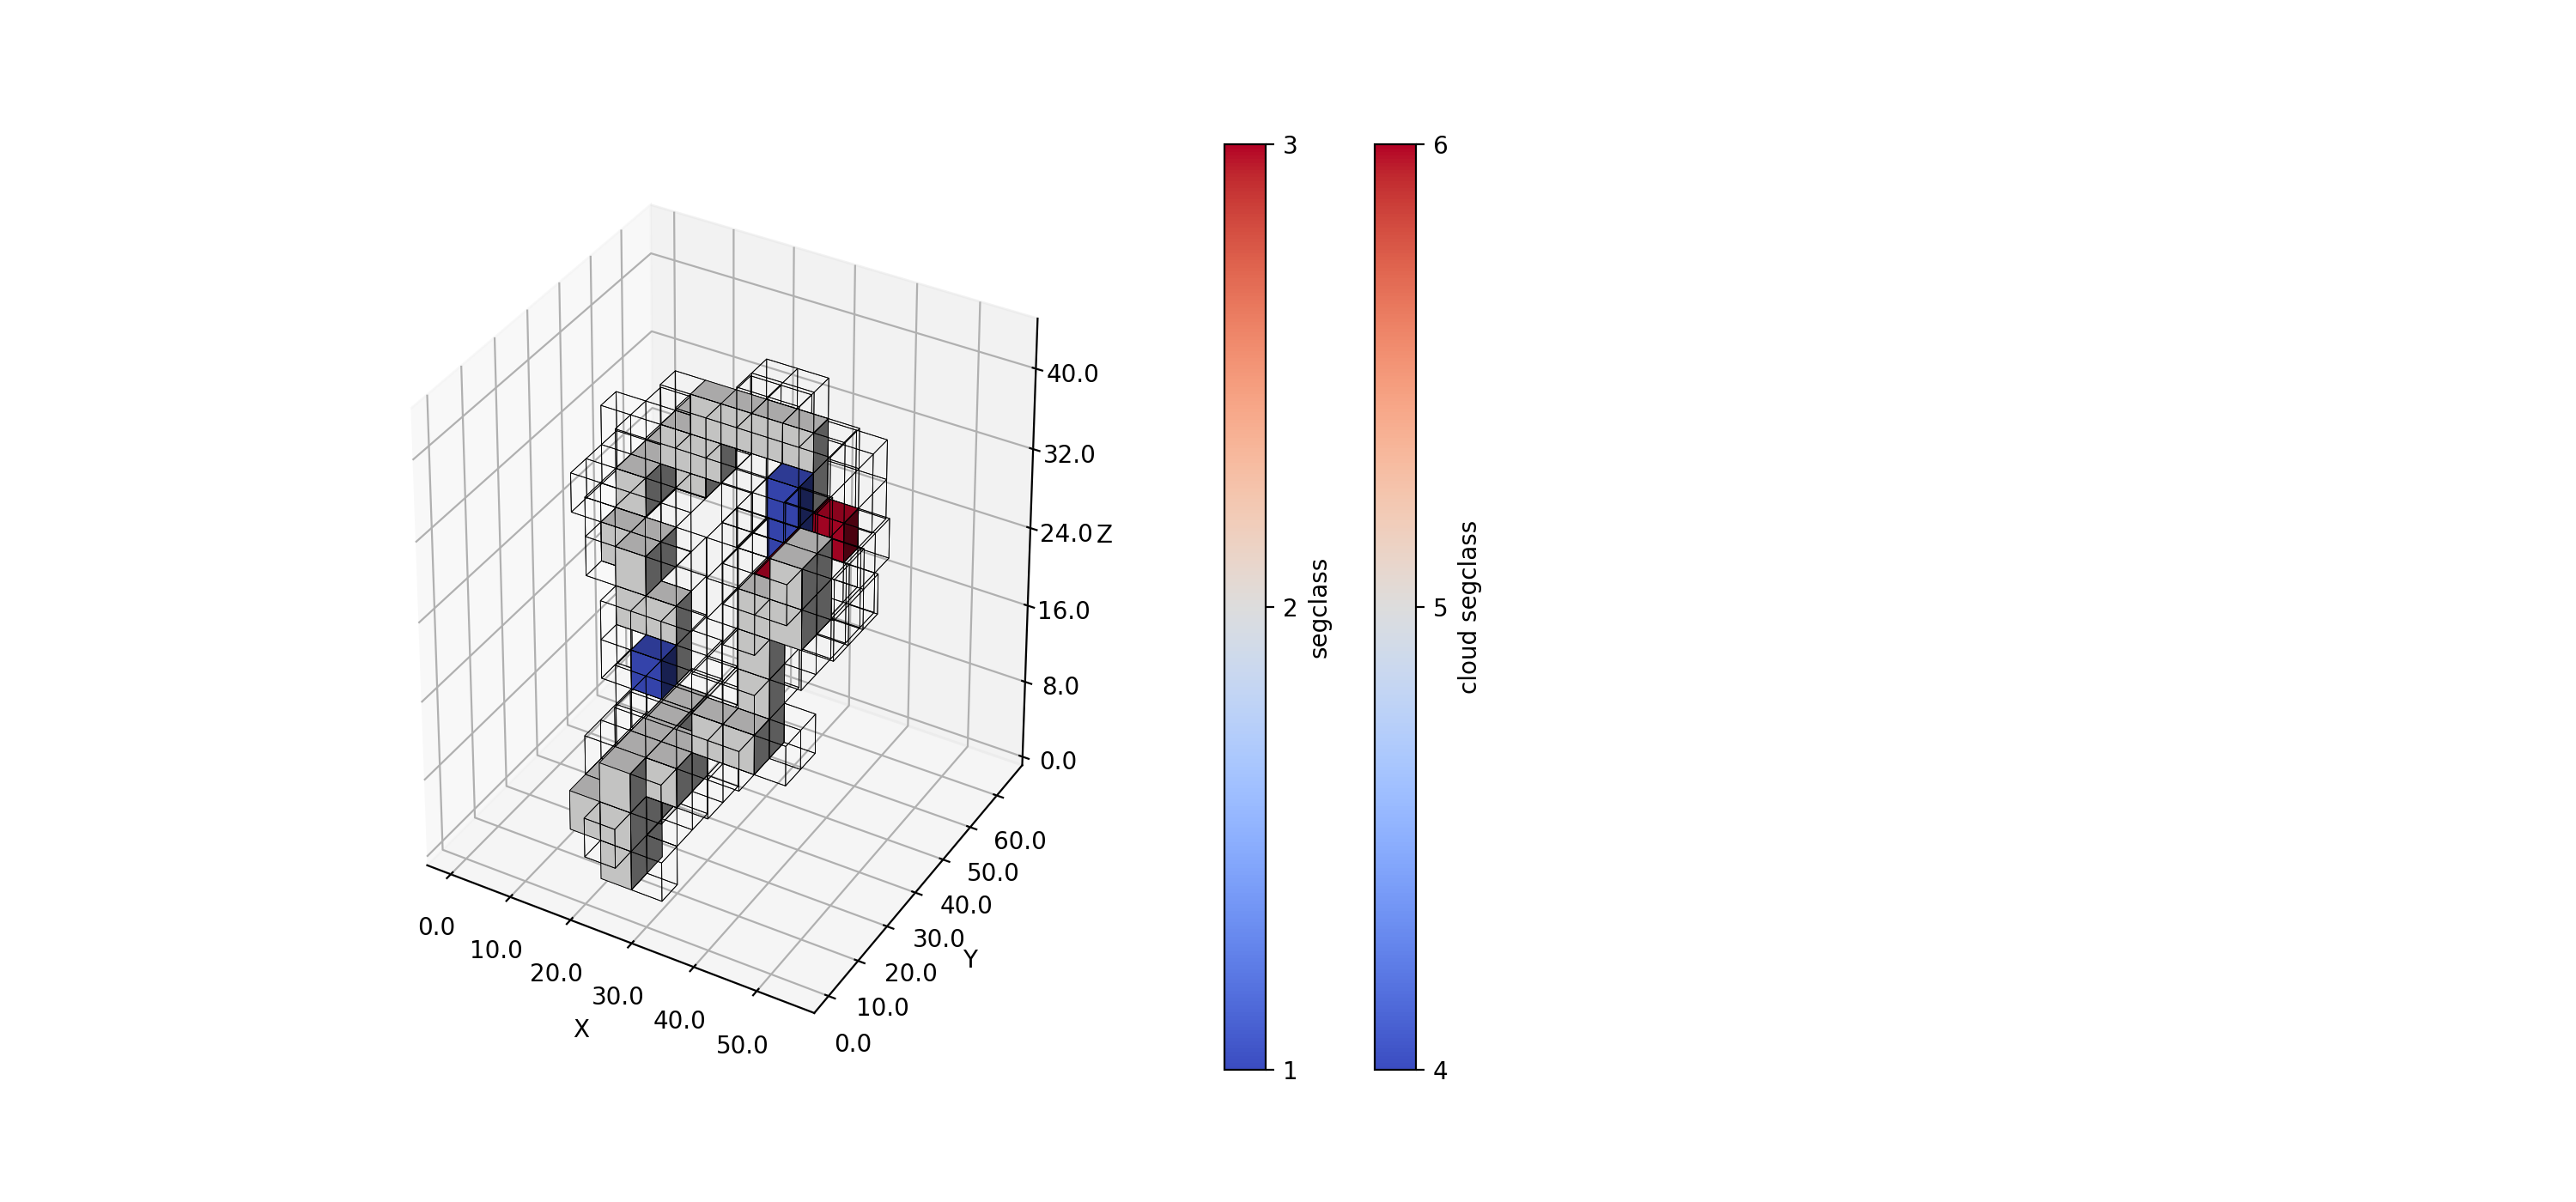

In [439]:
%matplotlib notebook
plot_3d_hits(ev_hits, value = 'particle_id')

print('small blob = 1000')
plot_3d_hits(ev_MC_hits1, value = 'segclass')
print('small blob = 1.5')
plot_3d_hits(ev_MC_hits2, value = 'segclass')

print('small blob = 1000')
plot_3d_vox(ev_MC_vox1, value = 'segclass')
print('small blob = 1.5')
plot_3d_vox(ev_MC_vox2[np.isin(ev_MC_vox2.segclass, [3, 6])], value = 'segclass')

#plot_3d_hits(ev_beer, coords = ['X', 'Y', 'Z'], value = 'E')
plot_3d_hits(ev_beersh_vox1, coords = ['xbin', 'ybin', 'zbin'], value = 'energy')
#plot_3d_hits(ev_beersh_vox2, coords = ['xbin', 'ybin', 'zbin'], value = 'energy')

print('small blob = 1000')
plot_3d_vox(ev_beersh_vox1[np.isin(ev_beersh_vox1.segclass, [3, 6])], coords = ['xbin', 'ybin', 'zbin'], value = 'segclass')
print('small blob = 1.5')
plot_3d_vox(ev_beersh_vox2[np.isin(ev_beersh_vox2.segclass, [3, 6])], coords = ['xbin', 'ybin', 'zbin'], value = 'segclass')

plot_cloud_voxels(ev_beersh_vox2, voxel_size, opacity = [1, 0])
#plot_cloud_voxels_and_hits(ev_beersh_vox1, ev_MC_hits1, voxel_size, opacity = [0, 0.5, 1])


# Funciones para hacer los plots válidos con coords y dataframes...

Se podría intentar pero ta dificil, sería algo rollo de entrada una tupla de tuplas de coordenadas 

((x1, y1, z1), (x2, y2, z2), ...), y una especie de mask que diga cual 

In [334]:
def plot_3d_vox(grid, hits_digitized, value='energy', coords = ['x', 'y', 'z'], th=0, edgecolor='k', linewidth = .3, cmap=mpl.cm.jet, opacity = 1):

    xmin, xmax = hits_digitized[coords[0]].min(), hits_digitized[coords[0]].max()
    ymin, ymax = hits_digitized[coords[1]].min(), hits_digitized[coords[1]].max()
    zmin, zmax = hits_digitized[coords[2]].min(), hits_digitized[coords[2]].max()

    nbinsX = int(np.ceil((xmax-xmin))) + 2
    nbinsY = int(np.ceil((ymax-ymin))) + 2
    nbinsZ = int(np.ceil((zmax-zmin))) + 2
    xarr = np.ones(shape=(nbinsX, nbinsY, nbinsZ))*th

    nonzeros = np.vstack([hits_digitized[coords[0]].values-xmin+1,
                          hits_digitized[coords[1]].values-ymin+1,
                          hits_digitized[coords[2]].values-zmin+1])
    nonzeros = nonzeros.astype(int)
    xarr[tuple(nonzeros)] = hits_digitized[value].values
    dim     = xarr.shape
    voxels  = xarr > th

    fig, gs, ax, axcb = grid 
    norm = mpl.colors.Normalize(vmin=xarr.min(), vmax=xarr.max())
    m    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    colors = np.asarray(np.vectorize(m.to_rgba)(xarr))
    colors = np.rollaxis(colors, 0, 4)

    ax.voxels(voxels, facecolors=colors * opacity, edgecolor=edgecolor, linewidth = linewidth)
    cb = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='vertical')

    ax.set_xlabel('X ')
    ax.set_ylabel('Y ')
    ax.set_zlabel('Z ')
    cb.set_label (value)


In [93]:
def plot_3d_hits(grid, hits, value='energy', coords = ['x', 'y', 'z'], cmap = mpl.cm.jet):
    
    fig, gs, ax, axcb = grid
    norm = mpl.colors.Normalize(vmin=0, vmax=hits.loc[:, value].max())

    m    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    colors = np.asarray(np.vectorize(m.to_rgba)(hits.loc[:, value]))
    colors = np.rollaxis(colors, 0, 2)

    ax.scatter(hits[coords[0]], hits[coords[1]], hits[coords[2]], c=colors, marker='o')
    cb = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='vertical')


    ax.set_xlabel('X ')
    ax.set_ylabel('Y ')
    ax.set_zlabel('Z ')
    cb.set_label (value)


In [119]:
def plot_adaption_hits_to_voxel_scale(event_hits, event_voxels, voxel_size, coords = ['x', 'y', 'z']):
    '''
    We want to plot the MC hits in order to visualize better how the neighbour classes went, so this function 
    scales the positions for them to coincide.
    
    Args:
        event_hits: DATAFRAME
    Labelled MC hits of an event.
        
        voxel_size: TUPLE
    Contains the size of the voxel for each dimension.
        
        coords: LIST
    List with the coordinate names in the dataframe.
        
    RETURNS:
        event_scaled_hits: DATAFRAME
    Copy of the input DF but with scaled coordinates to the voxel size.        
    '''
    
    event_scaled_hits = event_hits.copy()
    for coor, size in zip(coords, voxel_size):
        minsize = min(event_voxels[coor])
        event_scaled_hits[coor] = event_hits[coor] / size - minsize + 1
    return event_scaled_hits

In [95]:
def create_plot_grid(colorbar_num, figsize = (15, 15)):
    '''
    Returns a list with colorbar_num lenght, where each element is a tuple with 
    fig, gs and ax (common for all the elements) and an axcb, unique for each element 
    (the frame for the colorbar)
    '''
    fig  = plt.figure(figsize=figsize, frameon=False)
    gs   = fig.add_gridspec(2, 40)
    ax   = fig.add_subplot(gs[0, 0:16], projection = '3d')
    final_grid = []
    for i in range(colorbar_num):
        final_grid.append((fig, gs, ax, fig.add_subplot(gs[0, 18 + int(3 * i)])))
    
    return final_grid

In [133]:
# tengo q hacer una función que me busque como el mínimo bin de cada uno de los df a plotear tb,
# para que todas las cosas que plotee queden alineadas
def seach_min_values(dfs, is_MC):
    '''
    Tupla con los df a plotear y mask de cuales son MC y cuales beersheba (para saber las coord que usar)
    '''
    minsize, maxsize = [], []
    for df, mc in zip(dfs, is_MC):
        if mc:
            pass
            
    pass